In [296]:
%pip install numpy matplotlib colorcet requests

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/kobayashilab/.pyenv/versions/3.13.1/lib/python3.13/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
                           ~~~~~~~~~^^
FileNotFoundError: [Errno 2] No such file or directory
Note: you may need to restart the kernel to use updated packages.


# Definitions


In [25]:
import asyncio
import gzip
import pickle
from datetime import datetime
from logging import (
    NOTSET,
    DEBUG,
    INFO,
    WARNING,
    getLogger,
)
from pathlib import Path
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt

import numpy as np
import numpy.typing as npt
import torch


def get_notebook_path() -> Path:
    """
    https://pypi.org/project/ipynbname/
    https://github.com/msm1089/ipynbname/issues/17#issuecomment-1293269863
    """
    from IPython.core.getipython import get_ipython

    ip = get_ipython()
    assert ip is not None
    path: str = ip.user_ns["__vsc_ipynb_file__"]
    return Path(path)


def setup_logger():
    from logging import basicConfig, StreamHandler, FileHandler, Formatter

    handler_stream = StreamHandler()
    handler_file = FileHandler(
        get_notebook_path().with_suffix(".log"), encoding="utf-8"
    )
    formatter = Formatter(
        "%(asctime)s@ %(name)s [%(levelname)s] %(funcName)s: %(message)s"
    )
    handler_stream.setLevel(INFO)
    handler_file.setLevel(INFO)
    handler_stream.setFormatter(formatter)
    handler_file.setFormatter(formatter)
    basicConfig(level=NOTSET, handlers=[handler_stream, handler_file])


setup_logger()
logger = getLogger()
tztokyo = ZoneInfo("Asia/Tokyo")


import matplotlib
import matplotlib.cm
import matplotlib.colors
import matplotlib.font_manager
import matplotlib.ticker
from matplotlib import pyplot as plt
from matplotlib.artist import Artist
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from mpl_toolkits import axes_grid1
import colorcet as cc  # This import is required to use cmap of cet_* !


mpl = matplotlib
mpl.rcParams['image.cmap'] = 'cet_rainbow4'
# suppress messy info by matplotlib savefig as pdf
getLogger("fontTools.subset").setLevel(WARNING)


def setup_rcparams():
    plt.rcParams["xtick.direction"] = "in"
    plt.rcParams["ytick.direction"] = "in"
    plt.rcParams["xtick.top"] = True
    plt.rcParams["ytick.right"] = True
    plt.rcParams["figure.figsize"] = (4, 3)
    plt.rcParams["figure.dpi"] = 144
    # plt.rcParams["figure.autolayout"] = True  # tight_layout
    plt.rcParams["figure.constrained_layout.use"] = True  # constrained_layout
    plt.rcParams["errorbar.capsize"] = 3.0
    # plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.color"] = "lightgray"
    plt.rcParams["font.family"] = "Helvetica Now Text"
    plt.rcParams["svg.fonttype"] = "path"
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["axes.axisbelow"] = "line"


setup_rcparams()


def legend(*axes: Axes):
    hs, ls = zip(*[ax.get_legend_handles_labels() for ax in axes])
    axes[0].legend(sum(hs, []), sum(ls, []))


def colorize_yaxis(ax: Axes, tax: Axes, axcolor: str = "C0", taxcolor: str = "C1"):
    ax.set_ylabel(ax.get_ylabel(), color=axcolor)
    tax.set_ylabel(tax.get_ylabel(), color=taxcolor)
    # ax.tick_params("y", color=axcolor, labelcolor=axcolor)
    # tax.tick_params("y", color=taxcolor, labelcolor=taxcolor)
    ax.tick_params("y", which="both", colors=axcolor)
    tax.tick_params("y", which="both", colors=taxcolor)
    tax.spines["left"].set_color(axcolor)  # tax is over ax
    tax.spines["right"].set_color(taxcolor)


def align_yaxes(*axes: Axes, loc: float = 0.5, baseline: float = 0.0):
    assert 0.0 < loc < 1.0
    for ax in axes:
        ax.set_ymargin(0.0)
        vmin, vmax = ax.get_ylim()
        vmin = min(baseline, vmin, baseline - loc / (1 - loc) * (vmax - baseline))
        vmax = max(baseline, vmax, baseline + (1 - loc) / loc * (baseline - vmin))
        ax.set_ylim(vmin - 0.05 * (vmax - vmin), vmax + 0.05 * (vmax - vmin))


def generate_grids(
    figsize: tuple[int, int] = (4, 3),
    ncols: int = 1,
    nrows: int = 1,
    dpi: int = 72,
    **kwargs,
) -> tuple[Figure, axes_grid1.axes_grid.ImageGrid]:
    kw = dict(
        nrows_ncols=(nrows, ncols),
        # share_all=True,
        share_all=False,
        axes_pad=0.1,
        # cbar_size=f"{3 / ncols}%",
        cbar_size=0.1,
        cbar_mode="single",
    )
    kw = dict(kw, **kwargs)
    fig = plt.figure(figsize=(figsize[0] * ncols, figsize[1] * nrows), dpi=dpi)
    grids = axes_grid1.axes_grid.ImageGrid(fig, 111, **kw)
    return fig, grids


def get_fontnames() -> list[str | None]:
    fontpaths = mpl.font_manager.findSystemFonts()
    fontnames = []
    for path in fontpaths:
        try:
            name = mpl.font_manager.FontProperties(fname=path).get_name()
            fontnames.append(name)
        except RuntimeError as e:
            logger.warning("%s; %s", path, e)
    return sorted(set(fontnames))


def get_cmap(
    cmap: str | mpl.colors.Colormap,
    bad: str | None = None,
    # under: str | None = "dimgray",
    under: str | None = "deeppink",
    over: str | None = "deeppink",
) -> mpl.colors.Colormap:
    if isinstance(cmap, str):
        cmap = mpl.colormaps.get_cmap(cmap)
    else:
        cmap = cmap.copy()
    cmap.set_extremes(bad=bad, under=under, over=over)
    return cmap


def get_timestamp(postfix: str = "") -> str:
    return datetime.now(tztokyo).isoformat().replace(":", "=") + postfix


from typing import Any


def dump_to_pickle[T](obj: T, path: Path, overwrite: bool = False) -> T:
    if not overwrite:
        assert not path.exists()
    if path.suffix == ".gz":
        with gzip.open(path, "wb") as f:
            pickle.dump(obj, f, protocol=5)
        logger.info("Dumped gzipped-pickle to: %s", path)
    else:
        with path.open("wb") as f:
            pickle.dump(obj, f, protocol=5)
        logger.info("Dumped pickle to: %s", path)
    return obj


def load_pickle(path: Path) -> Any:
    if path.suffix == ".gz":
        with gzip.open(path, "rb") as f:
            return pickle.load(f)
    else:
        with path.open("rb") as f:
            return pickle.load(f)


def notify(message: str) -> str:
    import requests

    url = "https://designphotonics.issp.u-tokyo.ac.jp/mattermost/hooks/j1e75e1coty6zjamc1beu1o9wo"
    requests.post(url, json=dict(text=message))
    return message

In [3]:
import sys

if "../.." not in sys.path:
    sys.path.append("../..")

p_parent = Path(".")
p_log = Path("log")
p_log.mkdir(exist_ok=True)

# split-step beam propagation method

- https://chatgpt.com/share/677c482b-fb60-800f-a6f8-982d98e3c8c5
- [線形・非線形ビーム伝搬法とその適用範囲](https://www.jstage.jst.go.jp/article/lsj/36/10/36_628/_pdf)


## def (numpy)

In [6]:
from enum import StrEnum

import numpy as np
from numpy.fft import fft2, ifft2, fftfreq
from numpy.typing import NDArray
from tqdm.auto import trange


class DiffractionMode(StrEnum):
    PARAXIAL = "paraxial"
    """θ<~ 10°; 計算が安定"""
    WIDEANGLE = "wideangle"
    """θ<~ 25°; dxとdyが小さすぎると屈折率虚数で高周波成分が壊れる"""


def bpm_propagation(
    E0: NDArray[np.complex128],
    z_steps: int,
    dx: float,
    dy: float,
    dz: float,
    wavelength: float,
    n0: float,
    n_xy: NDArray[np.float64],
    iz_snap: NDArray[np.int64],
    diffraction_mode: DiffractionMode = DiffractionMode.PARAXIAL,
) -> NDArray[np.complex128]:
    """
    近軸近似に基づくスプリットステップBPMによるビーム伝搬を行う。

    Parameters
    ----------
    E0 : NDArray[np.complex128]
        z=0 の (x,y) 平面上の複素振幅分布 (Nx, Ny)
    z_steps : int
        z方向のステップ数
    dx, dy : float
        x, y, z 方向の空間サンプリング間隔 [m]
    wavelength : float
        真空中の波長 [m]
    n0 : float
        基準屈折率（全体の平均的な屈折率など）
    n_xy : NDArray[np.float64]
        (x,y) 平面上の屈折率分布 (Nx, Ny)
        ここでは z方向に均一(=変化なし)と仮定している。
    iz_snap: NDArray[np.int64]
        Eのスナップショットをとるステップ番号のリスト (0 <= iz <= z_steps)

    Returns
    -------
    E_snap : NDArray[np.complex128]
        z = iz_snap * dz の平面での複素振幅分布 (*iz_snap.shape, Nx, Ny)
    """
    # --- 基本定数等の準備 ---
    # 真空中の波数 k0 = 2π / λ
    k0 = 2.0 * np.pi / wavelength

    Nx, Ny = E0.shape

    # 周波数領域の格子ベクトル (kx, ky)
    # fftfreq(N, d=Δx) は -1/(2Δx) 〜 +1/(2Δx) の範囲で周波数を生成
    kx: NDArray[np.float64] = 2.0 * np.pi * fftfreq(Nx, d=dx)
    ky: NDArray[np.float64] = 2.0 * np.pi * fftfreq(Ny, d=dy)
    # メッシュグリッド (KX, KY) (Nx, Ny)
    KX, KY = np.meshgrid(kx, ky, indexing="ij")

    # --- 入力場をコピーして伝搬の計算に使う ---
    E = E0.copy()

    match diffraction_mode:
        case DiffractionMode.PARAXIAL:
            # --- フーリエ領域での回折項 (パラキシアル近似) ---
            #   H = exp( -i * (kx^2 + ky^2) / (2 * k0 * n0) * dz )
            #   これが各 zステップごとの回折演算に対応する
            H: NDArray[np.complex128] = np.exp(
                -1j * (KX**2 + KY**2) / (2.0 * k0 * n0) * dz
            )
        case DiffractionMode.WIDEANGLE:
            # --- "広角" (semi-paraxial) 回折演算子 (Fourierドメイン)
            #     kz(kx, ky) = sqrt((k0*n0)^2 - (kx^2 + ky^2))
            #     伝搬演算子 = exp( -i [ kz - k0 n0 ] dz )
            kz: NDArray[np.float64] = np.sqrt((k0 * n0) ** 2 - (KX**2 + KY**2))
            H: NDArray[np.complex128] = np.exp(1j * (kz - k0 * n0) * dz)
        case _:
            raise NotImplementedError

    # --- 屈折率による位相変調 (z方向に均一: n_xy は常に同じ) ---
    #   φ = k0 * (n_xy - n0) * dz
    #   z方向に均一なら毎ステップ同じ位相を掛けるだけ
    phase_term: NDArray[np.complex128] = np.exp(1j * k0 * (n_xy - n0) * dz)

    E_snap = np.zeros((*iz_snap.shape, *E.shape), dtype=E.dtype)
    E_snap[np.nonzero(iz_snap == 0)] = E

    # --- スプリットステップループ ---
    for iz in trange(z_steps):
        # 1) 回折項 (Fourierドメインで位相を掛ける)
        E_f = fft2(E)
        E_f *= H
        E = ifft2(E_f)

        # 2) 屈折率分布による位相変化を実空間で掛ける
        E *= phase_term

        # 保存
        E_snap[np.nonzero(iz_snap == iz + 1)] = E

    return E_snap

### シングルモードファイバー

シングルモードファイバーにちょっとでかめのガウスビームをぶちこんだ場合

  0%|          | 0/3000 [00:00<?, ?it/s]

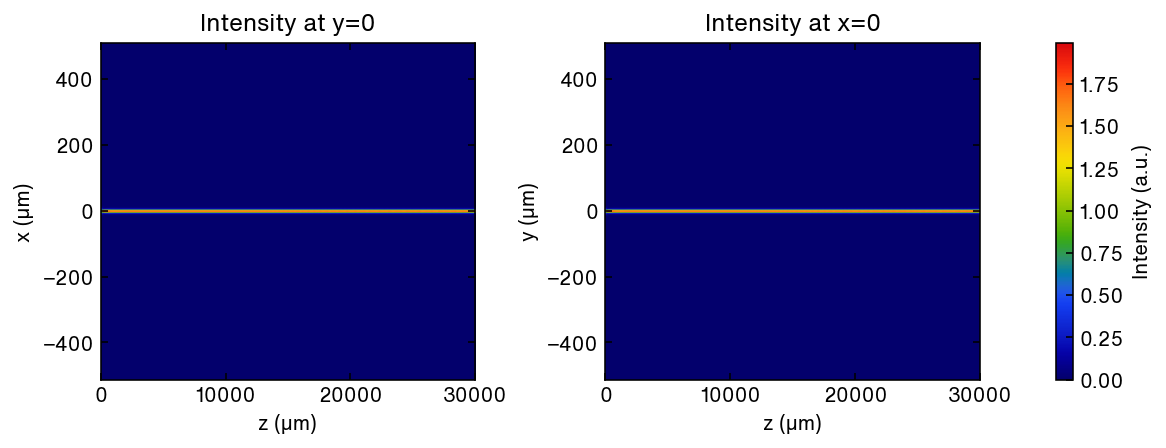

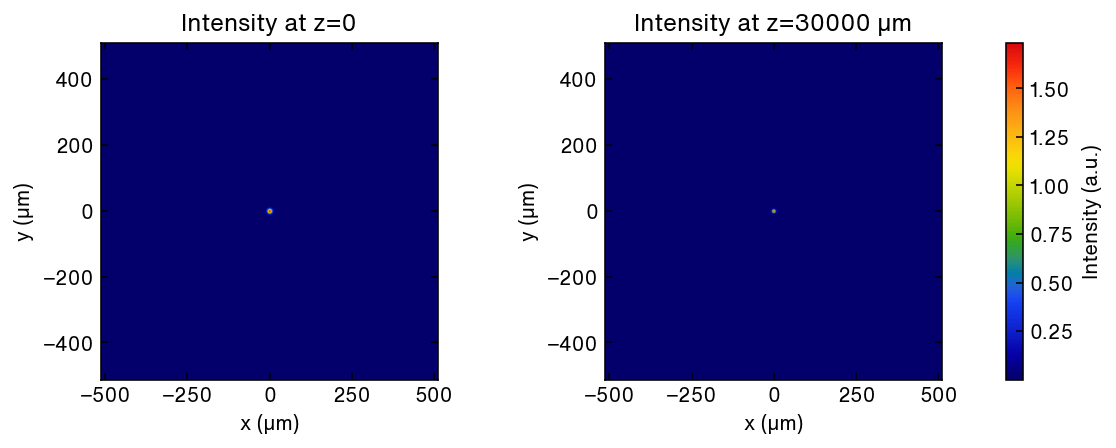

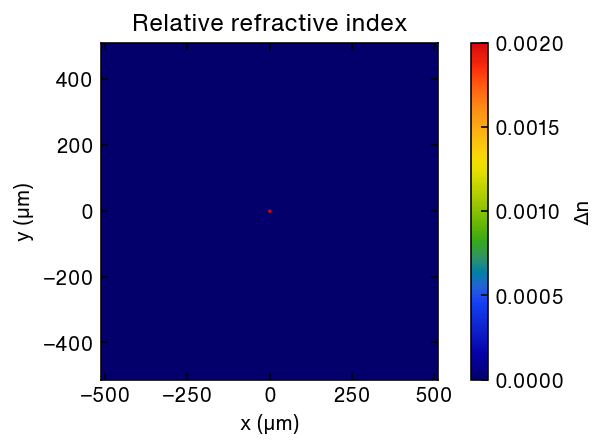

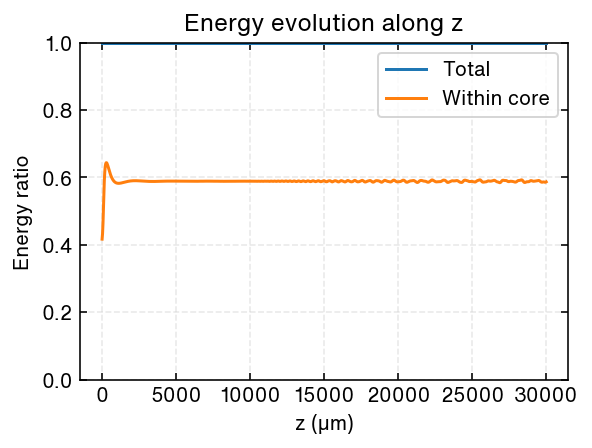

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# --------------------------------
# パラメータ定義
# --------------------------------
LX, LY, LZ = 600e-6, 600e-6, 30000e-6  # 領域サイズ[m]
dx, dy, dz = 2e-6, 2e-6, 10e-6         # サンプリング間隔[m]
wavelength = 1.532e-6                 # 波長[m]
n0 = 1.5                              # 基準屈折率
beam_waist = 10e-6                     # 入力ビームウェイスト[m]
radius = 5e-6                          # コア半径[m]
delta_n = 2e-3                         # コアの屈折率変化
max_snaps = 1000                       # スナップショット最大数

# --------------------------------
# 関数定義
# --------------------------------

def compute_grid(LX: float, LY: float, dx: float, dy: float) -> Tuple[np.ndarray, np.ndarray, int, int]:
    """
    領域サイズとサンプリング間隔からグリッド数および座標配列を計算
    """
    Nx = 1 << (round(LX / dx) - 1).bit_length()
    Ny = 1 << (round(LY / dy) - 1).bit_length()
    x = (np.arange(Nx) - Nx // 2) * dx
    y = (np.arange(Ny) - Ny // 2) * dy
    return x, y, Nx, Ny


def create_meshgrid(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    x, yから (Y,X) のメッシュグリッドを生成
    """
    return np.meshgrid(y, x, indexing="ij")


def compute_refractive_index(X: np.ndarray, Y: np.ndarray,
                              n0: float, radius: float, delta: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    屈折率分布とマスクを生成
    """
    n_xy = n0 * np.ones_like(X, dtype=np.float64)
    mask = (X**2 + Y**2) < radius**2
    n_xy[mask] = n0 + delta
    return n_xy, mask


def compute_snapshots(Nz: int, dz: float, max_snaps: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    z方向ステップ数からスナップショット位置を計算
    """
    iz_snap = np.linspace(0, Nz, min(max_snaps, Nz + 1)).round().astype(int)
    z_snap = iz_snap * dz
    return iz_snap, z_snap


def compute_intensity(E_snap: np.ndarray) -> np.ndarray:
    """
    電場スナップショットから強度に変換
    """
    return np.abs(E_snap) ** 2


def plot_intensity_slices(
    I_snap: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    z_snap: np.ndarray,
    dx: float,
    dy: float,
    dz: float,
    spatial_range: Optional[Tuple[float, float]] = None,
    z_range: Optional[Tuple[float, float]] = None
):
    """
    x=0およびy=0付近の断面 (x-z, y-z) をプロット
    spatial_range: y軸(µm)の表示範囲, z_range: x軸(µm)の表示範囲
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    iy0 = np.searchsorted(y, 0.0)
    ix0 = np.searchsorted(x, 0.0)
    # x-z断面
    extent_xz = (
        (z_snap[0] - dz/2) * 1e6,
        (z_snap[-1] + dz/2) * 1e6,
        (x[0] - dx/2) * 1e6,
        (x[-1] + dx/2) * 1e6,
    )
    axes[0].imshow(
        I_snap[:, iy0, :].T,
        origin='lower',
        aspect='auto',
        extent=extent_xz
    )
    axes[0].set(title="Intensity at y=0", xlabel="z (µm)", ylabel="x (µm)")
    # y-z断面
    extent_yz = (
        z_snap[0] * 1e6,
        z_snap[-1] * 1e6,
        (y[0] - dy/2) * 1e6,
        (y[-1] + dy/2) * 1e6,
    )
    axes[1].imshow(
        I_snap[:, :, ix0].T,
        origin='lower',
        aspect='auto',
        extent=extent_yz
    )
    axes[1].set(title="Intensity at x=0", xlabel="z (µm)", ylabel="y (µm)")

    # ユーザ指定の表示範囲を適用
    if z_range is not None:
        axes[0].set_xlim(z_range)
        axes[1].set_xlim(z_range)
    if spatial_range is not None:
        axes[0].set_ylim(spatial_range)
        axes[1].set_ylim(spatial_range)

    fig.colorbar(axes[1].images[0], ax=axes, label="Intensity (a.u.)")
    plt.show()


def plot_xy_planes(
    I_snap: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    iz_snap: np.ndarray,
    dz: float,
    x_range: Optional[Tuple[float, float]] = None,
    y_range: Optional[Tuple[float, float]] = None
):
    """
    入力面と終端面の x-y 強度分布をプロット
    x_range: x軸(µm)の表示範囲, y_range: y軸(µm)の表示範囲
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    for ax, idx, title in zip(axes, [0, -1], ['z=0', f'z={iz_snap[-1]*dz*1e6:.6g} µm']):
        extent = (
            (x[0] - dx/2) * 1e6,
            (x[-1] + dx/2) * 1e6,
            (y[0] - dy/2) * 1e6,
            (y[-1] + dy/2) * 1e6,
        )
        im = ax.imshow(I_snap[idx], origin='lower', extent=extent)
        ax.set(title=f"Intensity at {title}", xlabel="x (µm)", ylabel="y (µm)")
    # ユーザ指定の表示範囲を適用
    if x_range is not None:
        for ax in axes:
            ax.set_xlim(x_range)
    if y_range is not None:
        for ax in axes:
            ax.set_ylim(y_range)
    fig.colorbar(im, ax=axes.ravel().tolist(), label="Intensity (a.u.)")
    plt.show()


def plot_refractive_index(
    n_xy: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    n0: float,
    x_range: Optional[Tuple[float, float]] = None,
    y_range: Optional[Tuple[float, float]] = None
):
    """
    屈折率分布 (n_xy - n0) を可視化
    x_range: x軸(µm), y_range: y軸(µm)
    """
    fig, ax = plt.subplots()
    extent = (
        (x[0] - dx/2) * 1e6,
        (x[-1] + dx/2) * 1e6,
        (y[0] - dy/2) * 1e6,
        (y[-1] + dy/2) * 1e6,
    )
    im = ax.imshow(n_xy - n0, origin='lower', extent=extent)
    ax.set(title="Relative refractive index", xlabel="x (µm)", ylabel="y (µm)")
    # ユーザ指定の表示範囲を適用
    if x_range is not None:
        ax.set_xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)
    fig.colorbar(im, ax=ax, label="Δn")
    plt.show()


def plot_energy_evolution(
    I_snap: np.ndarray,
    mask: np.ndarray,
    z_snap: np.ndarray,
    z_range: Optional[Tuple[float, float]] = None,
    energy_range: Optional[Tuple[float, float]] = None
):
    """
    全体およびコア内エネルギーの変化をプロット
    z_range: z軸(µm), energy_range: エネルギー比の表示範囲
    """
    energy_total = I_snap.sum(axis=(1, 2))
    I_inner = I_snap.copy()
    I_inner[:, ~mask] = 0.0
    energy_inner = I_inner.sum(axis=(1, 2))
    plt.figure()
    plt.plot(z_snap * 1e6, energy_total / energy_total[0], label='Total')
    plt.plot(z_snap * 1e6, energy_inner / energy_total[0], label='Within core')
    plt.xlabel('z (µm)')
    plt.ylabel('Energy ratio')
    plt.ylim(0,1)
    plt.title('Energy evolution along z')
    plt.grid(which='both', linestyle='--', alpha=0.5)
    plt.legend()
    # ユーザ指定の表示範囲を適用
    if z_range is not None:
        plt.xlim(z_range)
    if energy_range is not None:
        plt.ylim(energy_range)
    plt.show()

# --------------------------------
# メイン処理
# --------------------------------
x, y, Nx, Ny = compute_grid(LX, LY, dx, dy)
X, Y = create_meshgrid(x, y)

E0 = np.exp(-(X**2 + Y**2) / (beam_waist**2)).astype(np.complex128)

n_xy, mask = compute_refractive_index(X, Y, n0, radius, delta_n)

Nz = round(LZ / dz)
iz_snap, z_snap = compute_snapshots(Nz, dz, max_snaps)

E_snap = bpm_propagation(
    E0, Nz, dx, dy, dz, wavelength, n0, n_xy, iz_snap,
    diffraction_mode=DiffractionMode.PARAXIAL
)

I_snap = compute_intensity(E_snap)

# 可視化 (必要に応じて範囲を指定)
plot_intensity_slices(I_snap, x, y, z_snap, dx, dy, dz)
plot_xy_planes(I_snap, x, y, iz_snap, dz)
plot_refractive_index(n_xy, x, y, n0)
plot_energy_evolution(I_snap, mask, z_snap)




### 旧コード

  0%|          | 0/3000 [00:00<?, ?it/s]

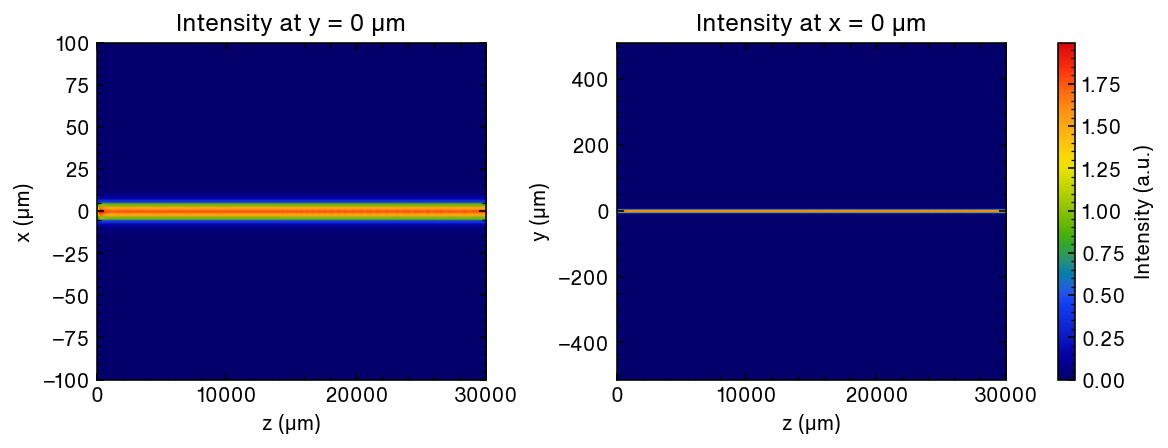

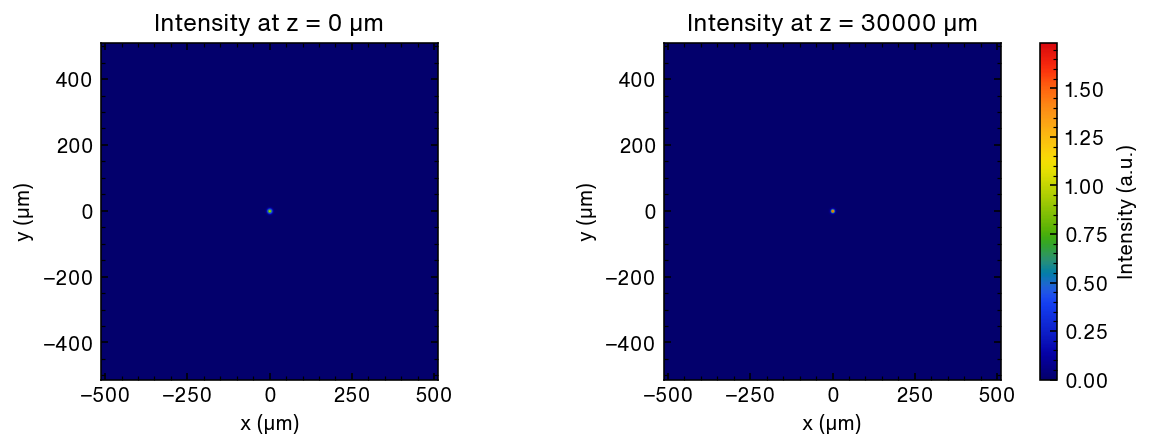

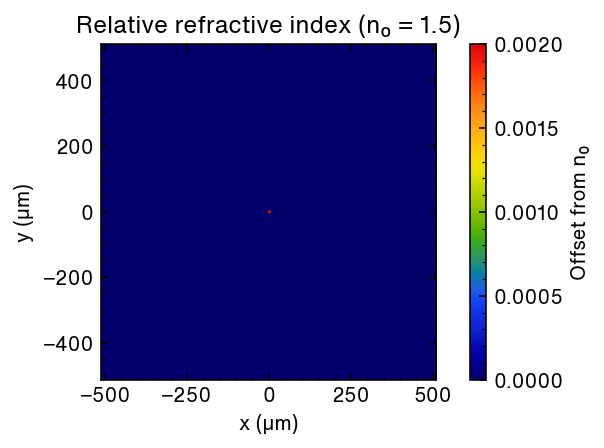

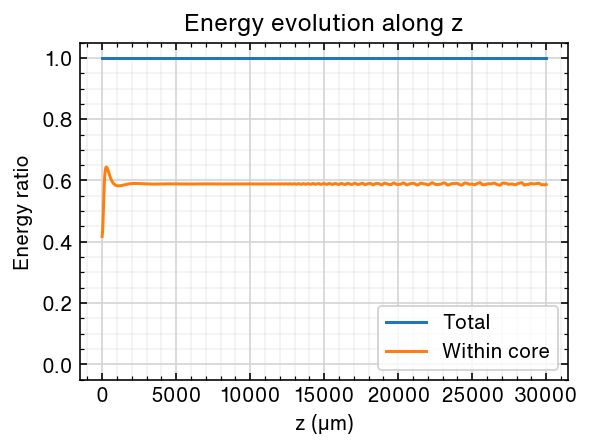

In [10]:

# 領域サイズ [m]
LX = 600e-6
LY = 600e-6
LZ = 30000e-6

# サンプリング間隔 [m]
dx = dy = 2e-6
dz = 10e-6

# パラメータ
wavelength = 1.532e-6  # 真空中の波長 [m]
n0 = 1.5               # 基準屈折率

# --- グリッド数を計算 ---
# round(LX / dx)は x方向のサンプル数を求めるが、
# 2^冪(パワーオブ2)にしてFFTが高速になるように調整している
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)  # z方向のステップ数

# --- x,y座標配列を作成 ---
#   (x[ i ] , y[ j ]) = ( (i - Nx/2)*dx, (j - Ny/2)*dy )
x = (np.arange(Nx) - Nx // 2) * dx
y = (np.arange(Ny) - Ny // 2) * dy

# meshgridはデフォルト (行,列)になりがちなので、indexing="ij"に注意
# ここではY, X = np.meshgrid(y, x, indexing="ij") としている
Y, X = np.meshgrid(y, x, indexing="ij")

# --- 入力面にガウスビームを定義 (単純化した例) ---
beam_waist = 10e-6  # ビームウエスト
E0 = np.exp(-(X**2 + Y**2) / (beam_waist**2)).astype(np.complex128)

# --- z方向に均一な屈折率分布 (例: コア円形領域) ---
# まずは全域を n0 とし、コア部分だけ +2e-3
n_xy = n0 * np.ones_like(E0, dtype=np.float64)
radius = 5e-6  # コアの半径 [m]
mask = (X**2 + Y**2) < radius**2  # コア領域のマスク (Trueがコア内)
n_xy[mask] = n0 + 2e-3            # コア領域だけ少し高い屈折率

# --- 記録するzステップ位置 (0からNzまでを最大1000ステップに分割) ---
iz_snap = np.linspace(0, Nz, min(1000, Nz + 1)).round().astype(np.int64)
z_snap = dz * iz_snap  # 実際のz座標 [m]

# --- BPMを実行してスナップショットを取得 ---
E_snap = bpm_propagation(
    E0,
    Nz,
    dx,
    dy,
    dz,
    wavelength,
    n0,
    n_xy,
    iz_snap,
    diffraction_mode=DiffractionMode.PARAXIAL,  # パラキシアル近似で実行
    # diffraction_mode=DiffractionMode.WIDEANGLE, # 広角近似を使いたい場合はこちらを有効化
)

# --- 強度分布に変換 (I = |E|^2) ---
I_snap = np.abs(E_snap) ** 2

# --- 以下、可視化 (matplotlib) ---
ax: Axes
# カラーマップ設定 (colorcetパッケージの "cet_rainbow4"など)
cmap = "cet_rainbow4"

# 可視化範囲 (vmin,vmax) を設定
vmin = min(0, I_snap.min())
vmax = max(1, I_snap.max())

# ---- y=0近傍および x=0近傍 の断面を z方向にプロット ----
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))

# 1つ目: y=0付近の断面(x-z断面)を可視化
ax = axr[0]
iyc = np.searchsorted(y, 0.0)  # y=0に最も近いインデックス
axim = ax.imshow(
    I_snap[:, iyc, :].T,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0] - dz / 2) * 1e6,   # プロットのz下限 (µmに変換)
        (z_snap[-1] + dz / 2) * 1e6, # プロットのz上限
        (x[0] - dx / 2) * 1e6,       # プロットのx下限
        (x[-1] + dx / 2) * 1e6,      # プロットのx上限
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylim(-100,100)
ax.set_ylabel("x (µm)")
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")

# 2つ目: x=0付近の断面(y-z断面)を可視化
ax = axr[1]
ixc = np.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0] * 1e6,     # z下限 (µm)
        z_snap[-1] * 1e6,    # z上限
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")

# 軸の共通設定
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")

# カラーバー
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

# ---- z=0(入力面)とz=終端(Nz)付近の (x-y)面分布を可視化 ----
vmin = min(0, I_snap[0].min(), I_snap[-1].min())
vmax = max(1, I_snap[0].max(), I_snap[-1].max())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))

# 左: z=0 の強度分布
ax = axr[0]
axim = ax.imshow(
    I_snap[0],
    cmap=cmap,
    origin="lower",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[0] * dz:.6g} µm")

# 右: z=終端 の強度分布
ax = axr[1]
axim = ax.imshow(
    I_snap[-1],
    cmap=cmap,
    origin="lower",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[-1] * dz:.6g} µm")

# 軸設定
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

# カラーバー
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

# ---- 屈折率分布 (n_xy - n0) の可視化 ----
fig, ax = plt.subplots()
axim = ax.imshow(
    n_xy - n0,
    cmap=cmap,
    origin="lower",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()

# ---- エネルギー量の変化を確認 ----
fig, ax = plt.subplots()

# エネルギー総和 (2次元積分) を計算
energy_total = I_snap.sum(axis=(-1, -2))

# コア内部だけのエネルギーを計算
I_snap_inner = I_snap.copy()
I_snap_inner[:, ~mask] = 0.0  # コア外をゼロにして和をとる
energy_inner = I_snap_inner.sum(axis=(-1, -2))

# プロット (最初の総エネルギーで規格化)
ax.plot(1e6 * z_snap, energy_total / energy_total[0], label="Total")
ax.plot(1e6 * z_snap, energy_inner / energy_total[0], label="Within core")
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (µm)")
ax.set_ylabel("Energy ratio")
ax.set_title("Energy evolution along z")

plt.show()

In [176]:
# https://www.thorlabs.co.jp/newgrouppage9.cfm?objectgroup_id=10417
# シングルモード条件
n_clad = 1.5
n_core = n_clad + 2e-3
na = np.sqrt(n_core**2 - n_clad**2).item()
v = 2 * np.pi * radius / wavelength * na
v_th = 2.405
m = v**2 / 2
v, m, v <= v_th

(1.5889544557256947, 1.2623881311852694, True)

### ちょっとマルチモードなファイバー

ちょっとマルチモードなファイバーにちょっとでかめのガウスビームをぶちこんだ場合

  0%|          | 0/1000 [00:00<?, ?it/s]

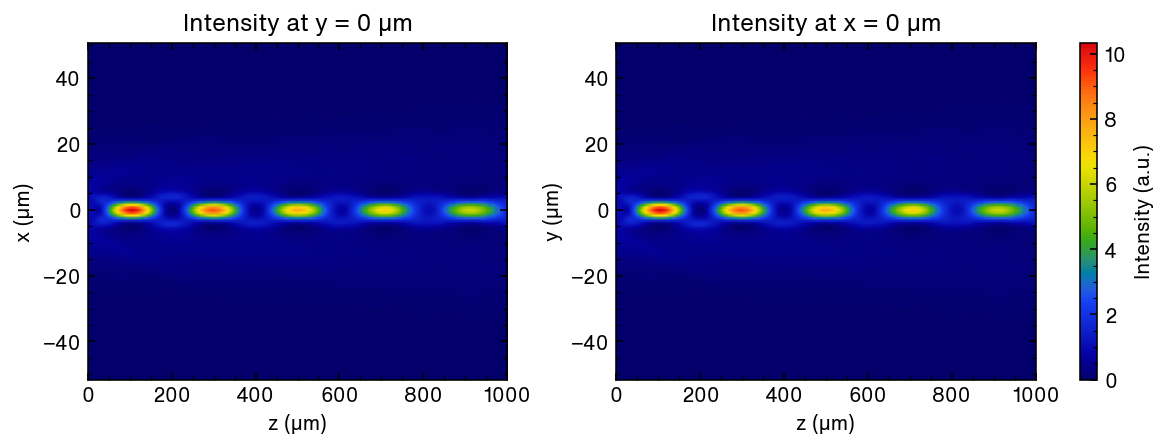

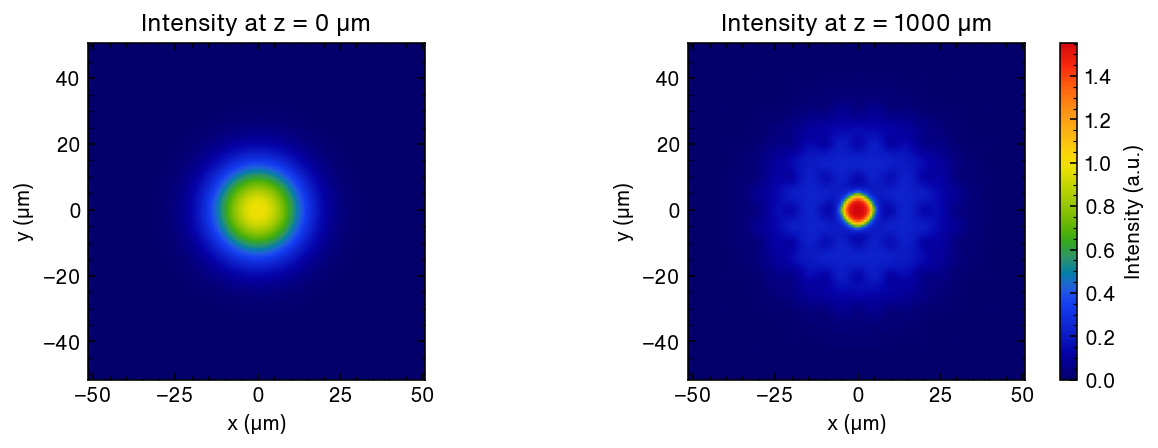

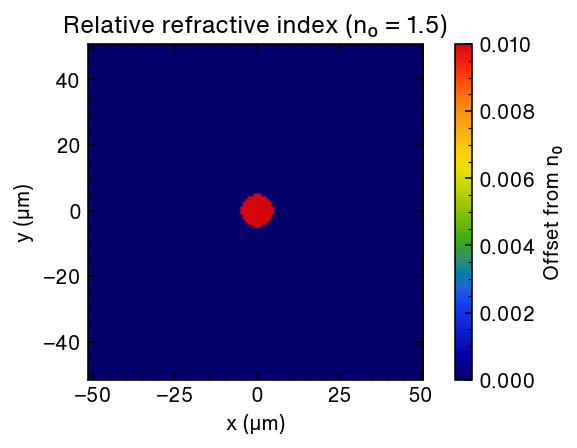

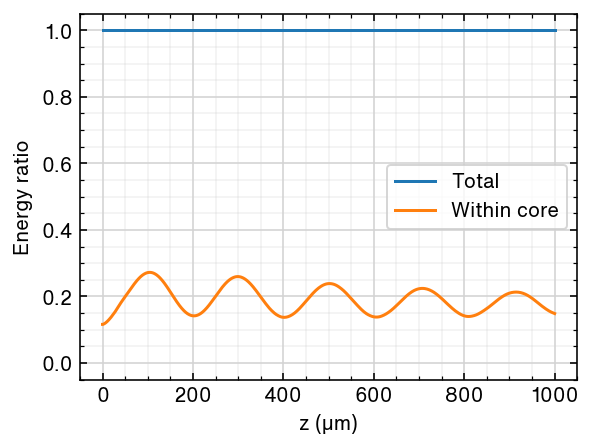

In [ ]:
# 領域サイズ
LX = 60e-6
LY = 60e-6
LZ = 1000e-6

# サンプリング間隔
dx = dy = 0.8e-6
dz = 1e-6

wavelength = 1.532e-6  # 波長
n0 = 1.5  # 基準屈折率

# グリッド数 (Nx, Nyは計算量削減のためにいちおう、2冪にしておく)
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

# 入力面にガウスビームを定義 (単純化した例)
x = (np.arange(Nx) - Nx // 2) * dx
y = (np.arange(Ny) - Ny // 2) * dy
Y, X = np.meshgrid(y, x, indexing="ij")
beam_waist = 20e-6
E0 = np.exp(-(X**2 + Y**2) / (beam_waist**2)).astype(np.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * np.ones_like(E0, dtype=np.float64)
radius = 5e-6
mask = (X**2 + Y**2) < radius**2
n_xy[mask] = n0 + 10e-3  # コア領域だけ少し高い屈折率

# 記録するZステップ位置
iz_snap = np.linspace(0, Nz, min(1000, Nz + 1)).round().astype(np.int64)
z_snap = dz * iz_snap

# 実行
E_snap = bpm_propagation(
    E0,
    Nz,
    dx,
    dy,
    dz,
    wavelength,
    n0,
    n_xy,
    iz_snap,
    diffraction_mode=DiffractionMode.PARAXIAL,
    # diffraction_mode=DiffractionMode.WIDEANGLE,
)
I_snap = np.abs(E_snap) ** 2


import matplotlib.pyplot as plt

ax: Axes

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min())
vmax = max(1, I_snap.max())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = np.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0] - dz / 2) * 1e6,
        (z_snap[-1] + dz / 2) * 1e6,
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = np.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0] * 1e6,
        z_snap[-1] * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

vmin = min(0, I_snap[0].min(), I_snap[-1].min())
vmax = max(1, I_snap[0].max(), I_snap[-1].max())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0],
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[0] * dz:.6g} µm")
ax = axr[1]
axim = ax.imshow(
    I_snap[-1],
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[-1] * dz:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

fig, ax = plt.subplots()
axim = ax.imshow(
    n_xy - n0,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()

fig, ax = plt.subplots()
energy_total = I_snap.sum(axis=(-1, -2))
I_snap_inner = I_snap.copy()
I_snap_inner[:, ~mask] = 0.0
energy_inner = I_snap_inner.sum(axis=(-1, -2))
ax.plot(1e6 * z_snap, energy_total / energy_total[0], label="Total")
ax.plot(1e6 * z_snap, energy_inner / energy_total[0], label="Within core")
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (µm)")
ax.set_ylabel("Energy ratio")
None

### sumiya導波路

  0%|          | 0/20000 [00:00<?, ?it/s]

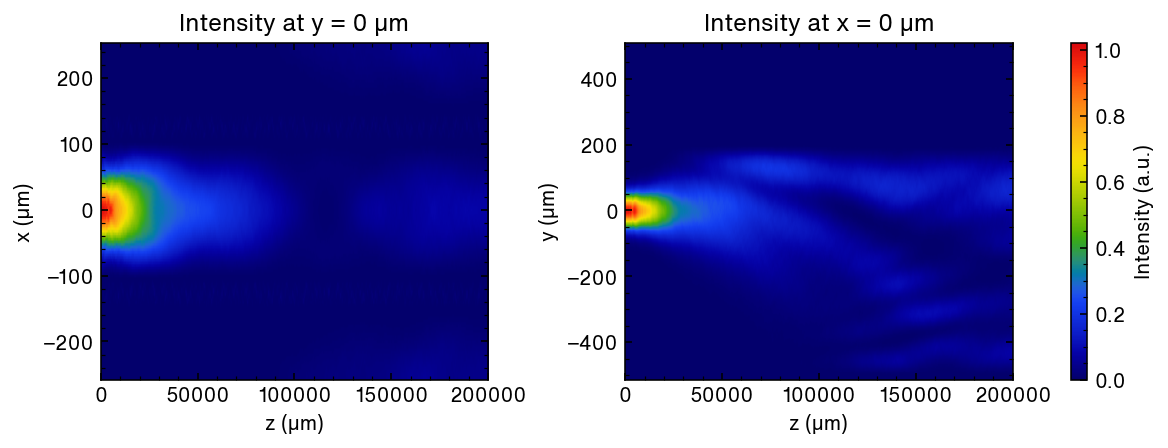

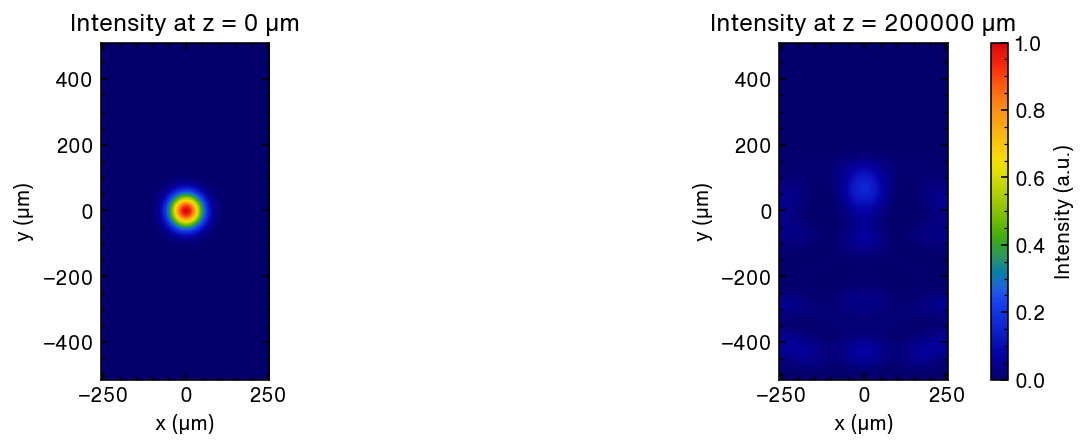

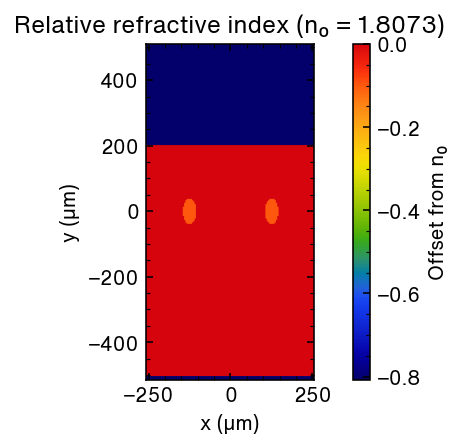

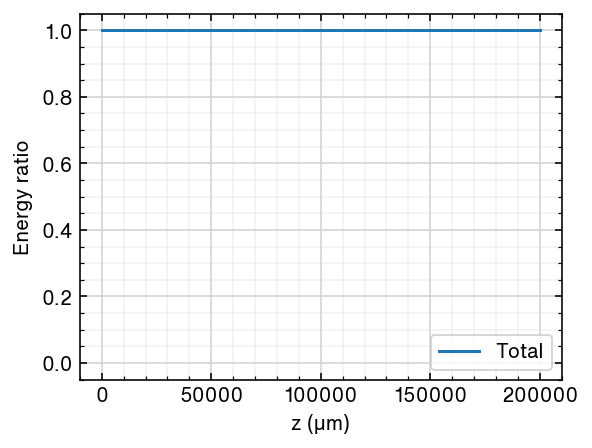

In [169]:
# 領域サイズ
LX = 400e-6
LY = 1000e-6
LZ = 200e-3

# サンプリング間隔
dx = dy = 4e-6
dz = 10e-6

wavelength = 1.532e-6  # 波長
n0 = 1.8073  # 基準屈折率

# グリッド数 (Nx, Nyは計算量削減のためにいちおう、2冪にしておく)
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

# 入力面にガウスビームを定義 (単純化した例)
x = (np.arange(Nx) - Nx // 2) * dx
y = (np.arange(Ny) - Ny // 2) * dy
Y, X = np.meshgrid(y, x, indexing="ij")
beam_waist = 70e-6
E0 = np.exp(-(X**2 + Y**2) / (beam_waist**2)).astype(np.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * np.ones_like(E0, dtype=np.float64)
rx = 20e-6
ry = 40e-6
cx = -125e-6
cy = 0e-6
mask1 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
n_xy[mask1] = n0 - 100e-3
cx = 125e-6
cy = 0e-6
mask2 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
n_xy[mask2] = n0 - 100e-3
radius = 5e-6
mask0 = (Y < -500e-6) | (200e-6 < Y)
n_xy[mask0] = 1.0

# 記録するZステップ位置
iz_snap = np.linspace(0, Nz, min(1000, Nz + 1)).round().astype(np.int64)
z_snap = dz * iz_snap

# 実行
E_snap = bpm_propagation(
    E0,
    Nz,
    dx,
    dy,
    dz,
    wavelength,
    n0,
    n_xy,
    iz_snap,
    diffraction_mode=DiffractionMode.PARAXIAL,
    # diffraction_mode=DiffractionMode.WIDEANGLE,
)
I_snap = np.abs(E_snap) ** 2


import matplotlib.pyplot as plt

ax: Axes

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min())
vmax = max(1, I_snap.max())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = np.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0] - dz / 2) * 1e6,
        (z_snap[-1] + dz / 2) * 1e6,
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = np.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0] * 1e6,
        z_snap[-1] * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

vmin = min(0, I_snap[0].min(), I_snap[-1].min())
vmax = max(1, I_snap[0].max(), I_snap[-1].max())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0],
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[0] * dz:.6g} µm")
ax = axr[1]
axim = ax.imshow(
    I_snap[-1],
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[-1] * dz:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

fig, ax = plt.subplots()
axim = ax.imshow(
    n_xy - n0,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0] - dx / 2) * 1e6,
        (x[-1] + dx / 2) * 1e6,
        (y[0] - dy / 2) * 1e6,
        (y[-1] + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()

fig, ax = plt.subplots()
energy_total = I_snap.sum(axis=(-1, -2))
# I_snap_inner = I_snap.copy()
# I_snap_inner[:, ~mask] = 0.0
# energy_inner = I_snap_inner.sum(axis=(-1, -2))
ax.plot(1e6 * z_snap, energy_total / energy_total[0], label="Total")
# ax.plot(1e6 * z_snap, energy_inner / energy_total[0], label="Within core")
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (µm)")
ax.set_ylabel("Energy ratio")
None

## def (torch)

In [ ]:
from enum import StrEnum

import torch
from torch.fft import fft2, ifft2, fftfreq
from tqdm.auto import trange
import base64
from IPython.display import HTML, display


class DiffractionMode(StrEnum):
    PARAXIAL = "paraxial"
    """θ<~ 10°; 計算が安定"""
    WIDEANGLE = "wideangle"
    """θ<~ 25°; dxとdyが小さすぎると屈折率虚数で高周波成分が壊れる"""


def bpm_propagation(
    E0: torch.Tensor,  # torch.Tensor[torch.complex128]
    z_steps: int,
    dx: float,
    dy: float,
    dz: float,
    wavelength: float,
    n0: float,
    n_xy: torch.Tensor,  # torch.Tensor[torch.float64]
    iz_snap: torch.Tensor,  # torch.Tensor[torch.int64]
    diffraction_mode: DiffractionMode = DiffractionMode.PARAXIAL,
) -> torch.Tensor:  # torch.Tensor[torch.complex128]
    """
    近軸近似に基づくスプリットステップBPMによるビーム伝搬を行う。

    Parameters
    ----------
    E0 : torch.Tensor[torch.complex128]
        z=0 の (x,y) 平面上の複素振幅分布 (Nx, Ny)
    z_steps : int
        z方向のステップ数
    dx, dy : float
        x, y, z 方向の空間サンプリング間隔 [m]
    wavelength : float
        真空中の波長 [m]
    n0 : float
        基準屈折率（全体の平均的な屈折率など）
    n_xy : torch.Tensor[np.float64]
        (x,y) 平面上の屈折率分布 (Nx, Ny)
        ここでは z方向に均一(=変化なし)と仮定している。
    iz_snap: torch.Tensor[np.int64]
        Eのスナップショットをとるステップ番号のリスト (0 <= iz <= z_steps)

    Returns
    -------
    E_snap : torch.Tensor[np.complex128]
        z = iz_snap * dz の平面での複素振幅分布 (*iz_snap.shape, Nx, Ny)
    """
    # --- 基本定数等の準備 ---
    # 真空中の波数 k0 = 2π / λ
    k0 = 2.0 * torch.pi / wavelength

    # --- 入力場をコピーして伝搬の計算に使う ---
    E = E0.clone()

    Nx, Ny = E.shape

    # 周波数領域の格子ベクトル (kx, ky)
    # fftfreq(N, d=Δx) は -1/(2Δx) 〜 +1/(2Δx) の範囲で周波数を生成
    kx: torch.Tensor = 2.0 * torch.pi * fftfreq(Nx, d=dx, device=E.device)
    ky: torch.Tensor = 2.0 * torch.pi * fftfreq(Ny, d=dy, device=E.device)
    # メッシュグリッド (KX, KY) (Nx, Ny)
    KX, KY = torch.meshgrid(kx, ky, indexing="ij")

    match diffraction_mode:
        case DiffractionMode.PARAXIAL:
            # --- フーリエ領域での回折項 (パラキシアル近似) ---
            #   H = exp( -i * (kx^2 + ky^2) / (2 * k0 * n0) * dz )
            #   これが各 zステップごとの回折演算に対応する
            H: torch.Tensor = torch.exp(-1j * (KX**2 + KY**2) / (2.0 * k0 * n0) * dz)
        case DiffractionMode.WIDEANGLE:
            # --- "広角" (semi-paraxial) 回折演算子 (Fourierドメイン)
            #     kz(kx, ky) = sqrt((k0*n0)^2 - (kx^2 + ky^2))
            #     伝搬演算子 = exp( -i [ kz - k0 n0 ] dz )
            kz: torch.Tensor = torch.sqrt((k0 * n0) ** 2 - (KX**2 + KY**2))
            H: torch.Tensor = torch.exp(1j * (kz - k0 * n0) * dz)
        case _:
            raise NotImplementedError

    # --- 屈折率による位相変調 (z方向に均一: n_xy は常に同じ) ---
    #   φ = k0 * (n_xy - n0) * dz
    #   z方向に均一なら毎ステップ同じ位相を掛けるだけ
    phase_term: torch.Tensor = torch.exp(1j * k0 * (n_xy - n0) * dz)

    E_snap = torch.zeros((*iz_snap.shape, *E.shape), dtype=E.dtype, device=E.device)
    E_snap[torch.nonzero(iz_snap == 0)] = E

    # --- スプリットステップループ ---
    for iz in trange(z_steps):
        # 1) 回折項 (Fourierドメインで位相を掛ける)
        E_f = fft2(E)
        E_f *= H
        E = ifft2(E_f)

        # 2) 屈折率分布による位相変化を実空間で掛ける
        E *= phase_term

        # 保存
        E_snap[torch.nonzero(iz_snap == iz + 1)] = E

    return E_snap

### シングルモードファイバー

シングルモードファイバーにちょっとでかめのガウスビームをぶちこんだ場合

  0%|          | 0/1000000 [00:00<?, ?it/s]

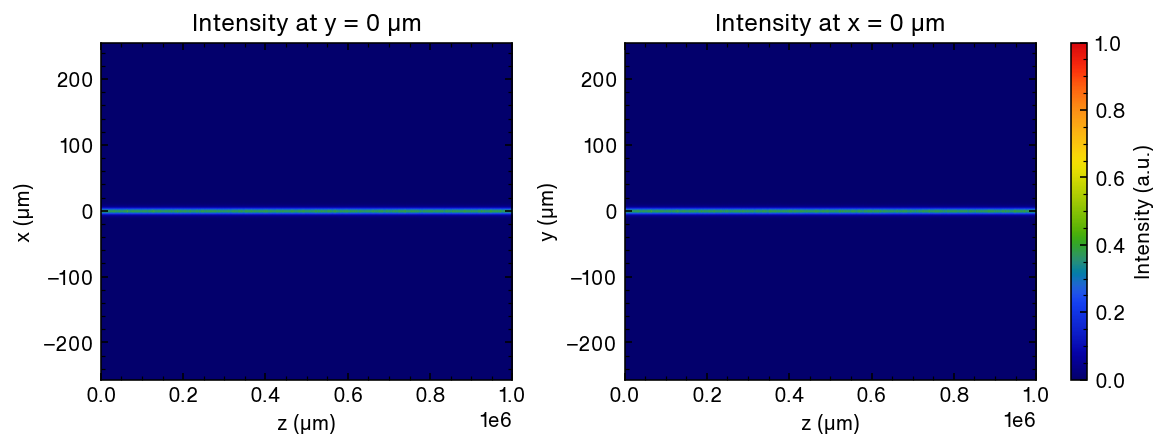

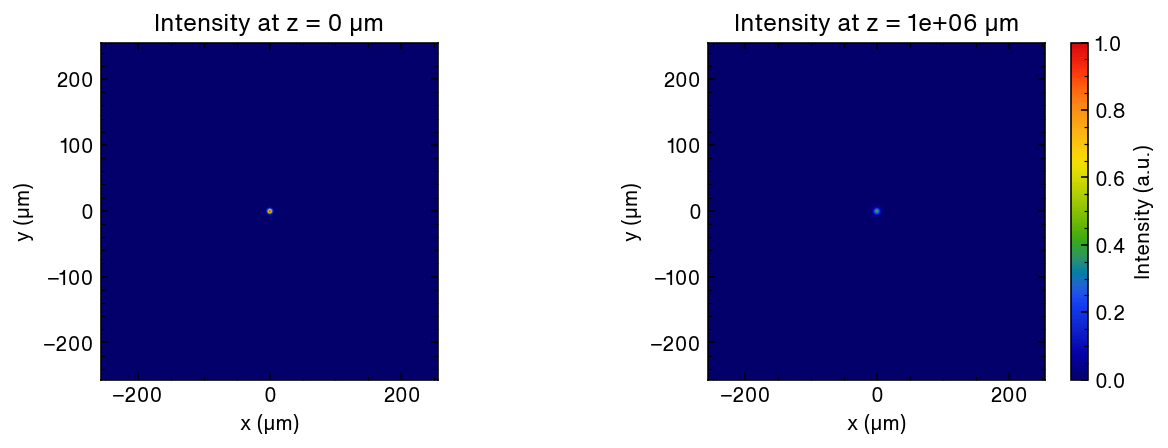

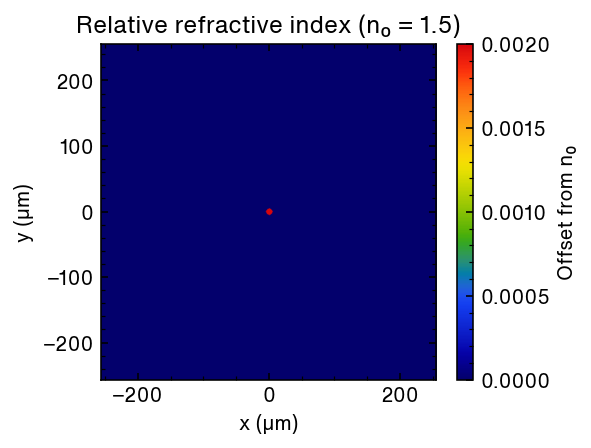

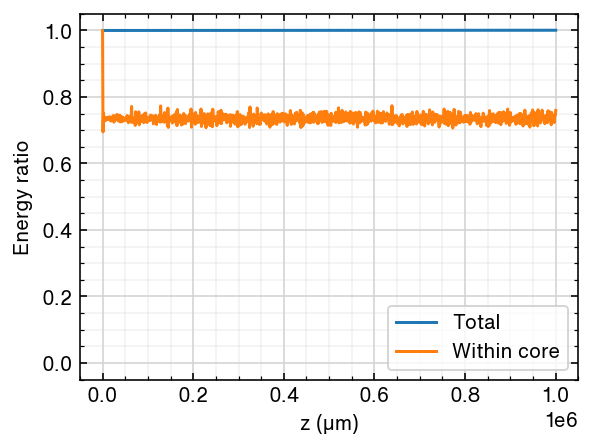

In [4]:
# 領域サイズ
LX = 500e-6
LY = 500e-6
LZ = 1000e-3

wavelength = 1.532e-6  # 波長

# サンプリング間隔
dx = dy = 1e-6
dz = 1e-6


n0 = 1.5  # 基準屈折率

# グリッド数 (Nx, Nyは計算量削減のためにいちおう、2冪にしておく)
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

device = torch.device("cuda:0")

# 入力面にガウスビームを定義 (単純化した例)
x = (torch.arange(Nx, device=device) - Nx // 2) * dx
y = (torch.arange(Ny, device=device) - Ny // 2) * dy
Y, X = torch.meshgrid(y, x, indexing="ij")
beam_waist = 5e-6
E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * torch.ones_like(E0, dtype=torch.float64, device=device)
radius = 5e-6
mask = (X**2 + Y**2) < radius**2
n_xy[mask] = n0 + 2e-3  # コア領域だけ少し高い屈折率

# 記録するZステップ位置
iz_snap = (
    torch.linspace(0, Nz, min(1000, Nz + 1), device=device)
    .round()
    .to(dtype=torch.int64)
)
z_snap = dz * iz_snap

# 実行
E_snap = bpm_propagation(
    E0,
    Nz,
    dx,
    dy,
    dz,
    wavelength,
    n0,
    n_xy,
    iz_snap,
    diffraction_mode=DiffractionMode.PARAXIAL,
    # diffraction_mode=DiffractionMode.WIDEANGLE,
)
I_snap = torch.abs(E_snap) ** 2


import matplotlib.pyplot as plt

ax: Axes

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min().item())
vmax = max(1, I_snap.max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = torch.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0].item() - dz / 2) * 1e6,
        (z_snap[-1].item() + dz / 2) * 1e6,
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = torch.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0].item() * 1e6,
        z_snap[-1].item() * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[0] * dz:.6g} µm")
ax = axr[1]
axim = ax.imshow(
    I_snap[-1].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[-1] * dz:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

fig, ax = plt.subplots()
axim = ax.imshow(
    n_xy.cpu().numpy() - n0,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()

fig, ax = plt.subplots()
energy_total = I_snap.sum(dim=(-1, -2))
I_snap_inner = I_snap.clone()
I_snap_inner[:, ~((X**2 + Y**2) < (radius * 2) ** 2)] = 0.0
energy_inner = I_snap_inner.sum(dim=(-1, -2))
ax.plot(
    1e6 * z_snap.cpu().numpy(),
    (energy_total / energy_total[0]).cpu().numpy(),
    label="Total",
)
ax.plot(
    1e6 * z_snap.cpu().numpy(),
    (energy_inner / energy_total[0]).cpu().numpy(),
    label="Within core",
)
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (µm)")
ax.set_ylabel("Energy ratio")
None

In [5]:
# https://www.thorlabs.co.jp/newgrouppage9.cfm?objectgroup_id=10417
# シングルモード条件
n_clad = 1.5
n_core = n_clad + 10e-3
na = np.sqrt(n_core**2 - n_clad**2).item()
v = 2 * np.pi * radius / wavelength * na
v_th = 2.405
m = v**2 / 2
v, m, v <= v_th

(3.5577412170992977, 6.328761283923596, False)

### ちょっとマルチモードなファイバー

ちょっとマルチモードなファイバーにちょっとでかめのガウスビームをぶちこんだ場合

  0%|          | 0/10000 [00:00<?, ?it/s]

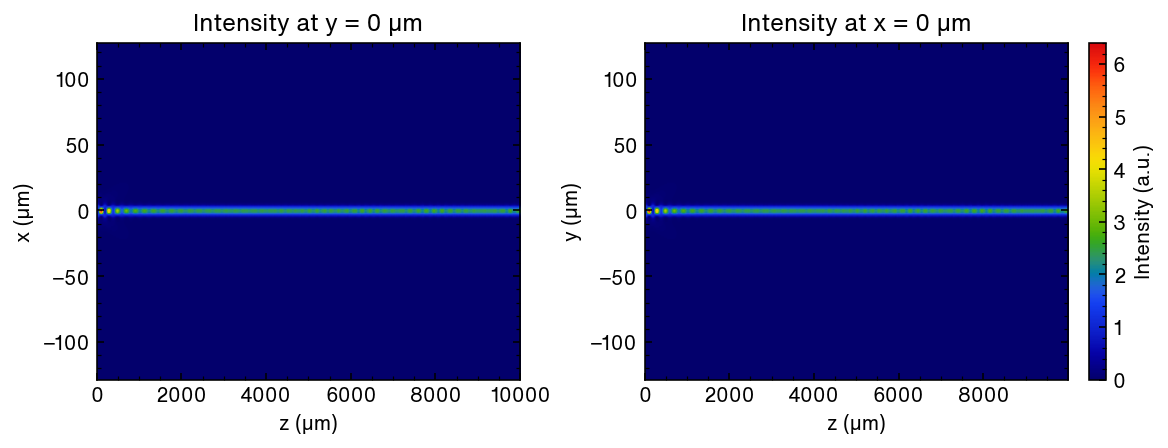

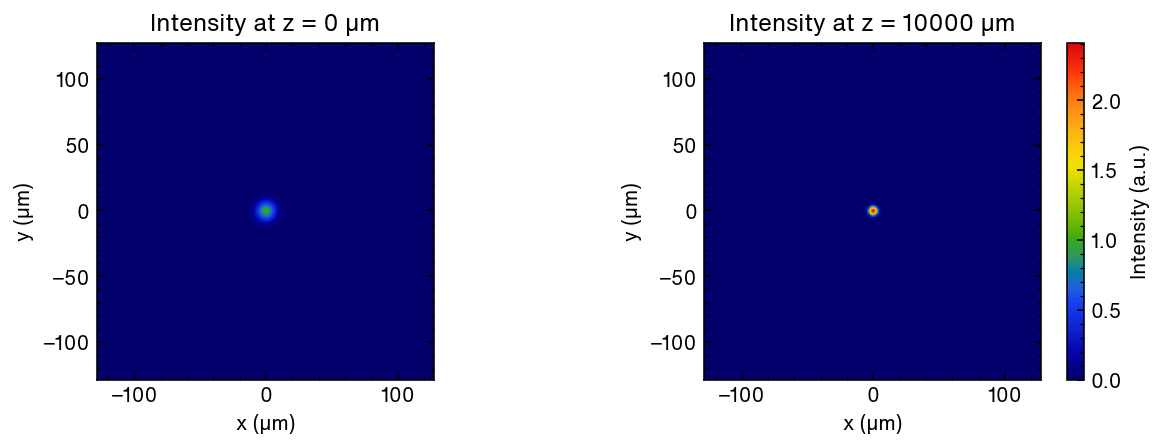

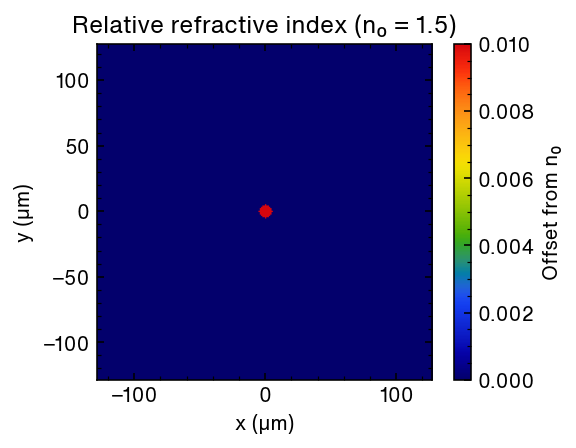

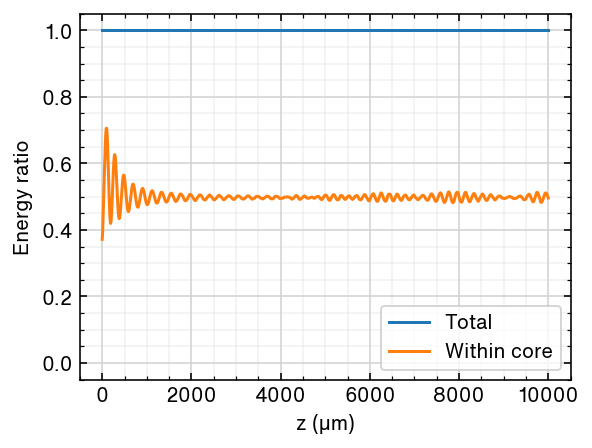

In [6]:
# 領域サイズ
LX = 200e-6
LY = 200e-6
LZ = 10000e-6

# サンプリング間隔
dx = dy = 1e-6
dz = 1e-6

wavelength = 1.532e-6  # 波長
n0 = 1.5  # 基準屈折率

# グリッド数 (Nx, Nyは計算量削減のためにいちおう、2冪にしておく)
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

device = torch.device("cuda:0")

# 入力面にガウスビームを定義 (単純化した例)
x = (torch.arange(Nx, device=device) - Nx // 2) * dx
y = (torch.arange(Ny, device=device) - Ny // 2) * dy
Y, X = torch.meshgrid(y, x, indexing="ij")
beam_waist = 10e-6
E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * torch.ones_like(E0, dtype=torch.float64, device=device)
radius = 5e-6
mask = (X**2 + Y**2) < radius**2
n_xy[mask] = n0 + 10e-3  # コア領域だけ少し高い屈折率

# 記録するZステップ位置
iz_snap = (
    torch.linspace(0, Nz, min(1000, Nz + 1), device=device)
    .round()
    .to(dtype=torch.int64)
)
z_snap = dz * iz_snap

# 実行
E_snap = bpm_propagation(
    E0,
    Nz,
    dx,
    dy,
    dz,
    wavelength,
    n0,
    n_xy,
    iz_snap,
    diffraction_mode=DiffractionMode.PARAXIAL,
    # diffraction_mode=DiffractionMode.WIDEANGLE,
)
I_snap = torch.abs(E_snap) ** 2


import matplotlib.pyplot as plt

ax: Axes

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min().item())
vmax = max(1, I_snap.max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = torch.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0].item() - dz / 2) * 1e6,
        (z_snap[-1].item() + dz / 2) * 1e6,
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = torch.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0].item() * 1e6,
        z_snap[-1].item() * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[0] * dz:.6g} µm")
ax = axr[1]
axim = ax.imshow(
    I_snap[-1].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_title(f"Intensity at z = {1e6 * iz_snap[-1] * dz:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()

fig, ax = plt.subplots()
axim = ax.imshow(
    n_xy.cpu().numpy() - n0,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()

fig, ax = plt.subplots()
energy_total = I_snap.sum(dim=(-1, -2))
I_snap_inner = I_snap.clone()
I_snap_inner[:, ~mask] = 0.0
energy_inner = I_snap_inner.sum(dim=(-1, -2))
ax.plot(
    1e6 * z_snap.cpu().numpy(),
    (energy_total / energy_total[0]).cpu().numpy(),
    label="Total",
)
ax.plot(
    1e6 * z_snap.cpu().numpy(),
    (energy_inner / energy_total[0]).cpu().numpy(),
    label="Within core",
)
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (µm)")
ax.set_ylabel("Energy ratio")
None

### sumiya導波路

3.9140941909286374e-05


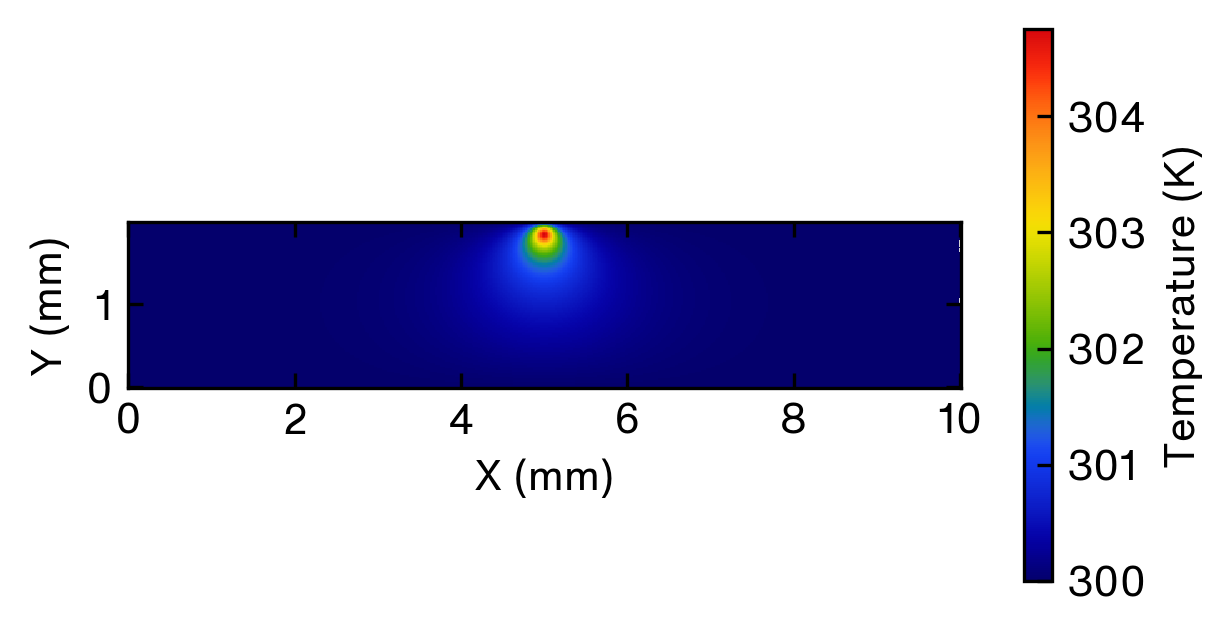

In [5]:
## 熱レンズのファイル読み出し

from scipy.interpolate import griddata
import re

cmap = "cet_rainbow4"

txt_path = Path.cwd() / "export_dataset.txt"
with txt_path.open() as f:
    txt_data = f.readlines()
npdata = []
for row in txt_data[9:]:
    row_list = re.split("[     |    ]", row.strip())
    row_splitted = []
    for el in row_list:
        if len(el) != 0:
            el_EXPs = el.split("E")
            if len(el_EXPs) == 2:
                el_val = float(el_EXPs[0]) * 10 ** (int(el_EXPs[1]))
            elif len(el_EXPs) == 1:
                el_val = float(el_EXPs[0])
            row_splitted.append(el_val)
    assert len(row_splitted) == 3
    npdata.append(row_splitted)
npdata = np.array(npdata)

# x, y の最小値と最大値からメッシュを作成
xi = np.arange(np.min(npdata[:, 0]), np.max(npdata[:, 0]), 2e-5)  # 解像度はお好みで調整
yi = np.arange(np.min(npdata[:, 1]), np.max(npdata[:, 1]), 2e-5)

X, Y = np.meshgrid(xi, yi)
Z = griddata(npdata[:, :2], npdata[:, 2], (X, Y), method="cubic")
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
im = ax.pcolormesh(X * 1000, Y * 1000, Z, cmap=cmap)
fig.colorbar(im, label="Temperature (K)")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_aspect("equal")
print((np.max(npdata) - 300) * 8.4e-6)

### akiyama waveguide

### ploexample

### 熱レンズなどの考慮

In [ ]:
import gc


def Tlens(n_xy, npdata):
    # 熱レンズの設定
    T0 = 300
    dndT = 8.4e-6
    cTLX, cTLY = 5e-3, 1.85e-3
    x1 = (np.arange(Nx) - Nx // 2) * dx
    y1 = (np.arange(Ny) - Ny // 2) * dy
    Y1, X1 = np.meshgrid(y1, x1, indexing="ij")
    Temp_xy = (
        torch.from_numpy(
            griddata(
                np.column_stack((npdata[:, 0] - cTLX, npdata[:, 1] - cTLY)),
                npdata[:, 2],
                (X1, Y1),
                method="cubic",
            )
        )
        .float()
        .cuda()
    )
    n_xy += (Temp_xy - T0) * dndT
    mask0 = (Y < air_down) | (air_up < Y)
    n_xy[mask0] = 1.0
    n_xy[(150e-6 < Y) & (Y < air_up)] = n0
    return n_xy


def gain(n_xy):
    # 消衰係数の設定
    jK = -1.2e-6 * 1j * (0.75 / 0.4)
    # jK = 0 * 1j
    K_xy = (
        2 * jK * torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)
    )
    n_xy += K_xy
    return n_xy


def ninc(n_xy, bwx, bwy, na):
    # na = 1e-4
    n_xy += na * torch.exp(-(2 * X**2 / (bwx**2) + 2 * Y**2 / (bwy**2))).to(
        dtype=torch.complex128
    )
    return n_xy


# 領域サイズ
LX = 1000e-6
LY = 4000e-6
LZ = 200e-3

wavelength = 1.532e-6  # 波長
n0 = 1.8073  # 基準屈折率

# サンプリング間隔
dx = dy = wavelength * 5
dz = 20e-6

# グリッド数 (Nx, Nyは計算量削減のためにいちおう、2冪にしておく)
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

device = torch.device("cuda:0")
item_dict = {}

save_cfolder = f"20240120_multina_Z{round(LZ*1000)}mm"
save_folder = Path.cwd() / save_cfolder
if not save_folder.exists():
    save_folder.mkdir()

delta_n = 2e-3
for na in (1e-6, 1e-5, 2e-5, 5e-5, 1e-4, 1e-3, 1e-2, 1e-1):
    # for delta_n in (1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1):
    gc.collect()
    # 入力面にガウスビームを定義 (単純化した例)
    x = (torch.arange(Nx, device=device) - Nx // 2) * dx
    y = (torch.arange(Ny, device=device) - Ny // 2) * dy
    Y, X = torch.meshgrid(y, x, indexing="ij")
    beam_waist = 45e-6
    E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

    # z方向に均一な屈折率分布 (例: コア円形領域)
    n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)

    #レーザー加工領域の屈折率変化設定
    ###################################
    spots = 3
    cl_R = 50e-6
    X_interval = 250e-6
    
    csx, csy = -cl_R * np.cos(1 * np.pi / 4), cl_R * np.sin(1 * np.pi / 4)
    # delta_n = 1e-2
    # 加工領域の設定(6本)
    for i in range(spots):
        ry = 20e-6
        rx = ry / 3
        cx = -(X_interval / 2 + cl_R * np.cos(i * np.pi / 4)) - csx
        cy = cl_R * np.sin(i * np.pi / 4) - csy
        mask1 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
        n_xy[mask1] = n0 - delta_n
        cx = X_interval / 2 - cl_R * np.cos(i * np.pi / 4) - csx
        cy = cl_R * np.sin(i * np.pi / 4) - csy
        mask2 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
        n_xy[mask2] = n0 - delta_n
    ##########################################

    #コア内に弱いガウシアン状変化を重畳。屈折率変化はnaの大きさ
    # n_xy = ninc(n_xy, 125e-6, 50e-6, na)
    # n_xy = gain(n_xy)

    #空気の設定
    air_up, air_down = 150e-6, -1850e-6
    mask0 = (Y < air_down) | (air_up < Y)
    n_xy[mask0] = 1.0

    Eloop = E0
    for i in range(1):
        # 実行
        # 記録するZステップ位置
        iz_snap = torch.linspace(0, Nz, min(100, Nz + 1)).round().to(dtype=torch.int64)
        z_snap = dz * iz_snap
        E_snap = bpm_propagation(
            Eloop,
            Nz,
            dx,
            dy,
            dz,
            wavelength,
            n0,
            n_xy,
            iz_snap,
            diffraction_mode=DiffractionMode.PARAXIAL,
            # diffraction_mode=DiffractionMode.WIDEANGLE,
        )
    final_E_snap = E_snap
    I_snap = torch.abs(final_E_snap) ** 2

    import matplotlib.pyplot as plt

    ax: Axes
    waveguideX, waveguideY = 300e-6, 150e-6
    maskWG = (
        (X < waveguideX / 2)
        & (X > -waveguideX / 2)
        & (Y < waveguideY / 2)
        & (Y > -waveguideY / 2)
    )

    cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

    vmin = min(0, I_snap.min().item())
    vmax = max(1, I_snap.max().item())
    fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
    ax = axr[0]
    iyc = torch.searchsorted(y, 0.0)
    axim = ax.imshow(
        I_snap[:, iyc, :].T.cpu().numpy(),
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(
            (z_snap[0].item() - dz / 2) * 1e6,
            (z_snap[-1].item() + dz / 2) * 1e6,
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
        ),
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_ylabel("x (µm)")
    ax.set_ylim(-250, 250)
    ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
    ax = axr[1]
    ixc = torch.searchsorted(x, 0.0)
    axim = ax.imshow(
        I_snap[:, :, ixc].T.cpu().numpy(),
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(
            z_snap[0].item() * 1e6,
            z_snap[-1].item() * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_ylabel("y (µm)")
    ax.set_ylim(-500, 500)
    ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
    for ax in axr:
        ax.minorticks_on()
        ax.set_xlabel("z (µm)")
    cbar = fig.colorbar(axim, label="Intensity (a.u.)")
    cbar.minorticks_on()
    save_file1 = f"XZandYZ_n{na:e}.png"
    save_path1 = save_folder / save_file1
    fig.savefig(save_path1)

    vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
    vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
    fig, axr = plt.subplots(1, 3, figsize=(4 * 3, 3))
    ax = axr[0]
    axim = ax.imshow(
        I_snap[0].cpu().numpy(),
        cmap=cmap,
        origin="lower",
        # aspect="auto",
        extent=(
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
        vmin=0,
        vmax=I_snap[0].max().item(),
    )
    ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
    ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
    ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[0].item() * dz):.6g} mm")
    cbar = fig.colorbar(axim, label="Intensity (a.u.)")
    cbar.minorticks_on()
    ax = axr[1]
    axim = ax.imshow(
        I_snap[len(iz_snap) // 10].cpu().numpy(),
        cmap=cmap,
        origin="lower",
        # aspect="auto",
        extent=(
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
        vmin=0,
        vmax=I_snap[len(iz_snap) // 10].max().item(),
    )
    ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
    ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
    ax.set_title(
        f"Intensity at z = {round(1e3 * iz_snap[len(iz_snap) // 10].item() * dz):.6g} mm"
    )
    cbar = fig.colorbar(axim, label="Intensity (a.u.)")
    cbar.minorticks_on()
    ax = axr[2]
    axim = ax.imshow(
        I_snap[-1].cpu().numpy(),
        cmap=cmap,
        origin="lower",
        # aspect="auto",
        extent=(
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
        vmin=0,
        vmax=I_snap[-1].max().item(),
    )
    ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
    ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
    ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[-1].item() * dz):.6g} mm")
    cbar = fig.colorbar(axim, label="Intensity (a.u.)")
    cbar.minorticks_on()
    for ax in axr:
        ax.minorticks_on()
        ax.set_xlabel("x (µm)")
        ax.set_ylabel("y (µm)")

    save_file2 = f"XYprofile_diffZ_n{na:e}.png"
    save_path2 = save_folder / save_file2
    fig.savefig(save_path2)

    # n_xy[~maskWG] = 1.0
    fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
    ax = axr[0]
    axim = ax.imshow(
        (n_xy.cpu().numpy() - n0).real,
        cmap=cmap,
        origin="lower",
        # aspect="auto",
        extent=(
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
    )
    ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    cbar = fig.colorbar(axim, label="Offset from n₀")
    cbar.minorticks_on()
    ax = axr[1]
    axim = ax.imshow(
        (n_xy.cpu().numpy() - n0).imag,
        cmap=cmap,
        origin="lower",
        # aspect="auto",
        extent=(
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
    )
    axim = ax.imshow(
        (n_xy.cpu().numpy() - n0).imag,
        cmap=cmap,
        origin="lower",
        # aspect="auto",
        extent=(
            (x[0].item() - dx / 2) * 1e6,
            (x[-1].item() + dx / 2) * 1e6,
            (y[0].item() - dy / 2) * 1e6,
            (y[-1].item() + dy / 2) * 1e6,
        ),
    )
    ax.set_title(f"Extinction coefficient")
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    cbar = fig.colorbar(axim, label="Offset from n₀")
    cbar.minorticks_on()
    save_file3 = f"nkprofile_n{na:e}.png"
    save_path3 = save_folder / save_file3
    fig.savefig(save_path3)

    energy_total = I_snap.sum(dim=(-1, -2))
    I_snap_inner = I_snap.clone()
    I_snap_inner[:, ~maskWG] = 0.0
    energy_inner = I_snap_inner.sum(dim=(-1, -2))
    item_dict[na] = [
        1e6 * z_snap.cpu().numpy(),
        (energy_total / energy_total[0]).cpu().numpy(),
        (energy_inner / energy_total[0]).cpu().numpy(),
    ]
fig, ax = plt.subplots()
for key in item_dict.keys():
    # ax.plot(
    #     item_dict[key][0] * 1e-3,
    #     item_dict[key][1],
    #     label=r"Total $\Delta$ n=" + str(key),
    # )
    ax.plot(
        item_dict[key][0] * 1e-3,
        item_dict[key][2],
        label=r"$\Delta$ n+=" + str(key),
    )
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (mm)")
ax.set_ylabel("Energy ratio")
save_path4 = save_folder / "energy_ratio.png"
fig.savefig(save_path4)
None

### saisyu

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

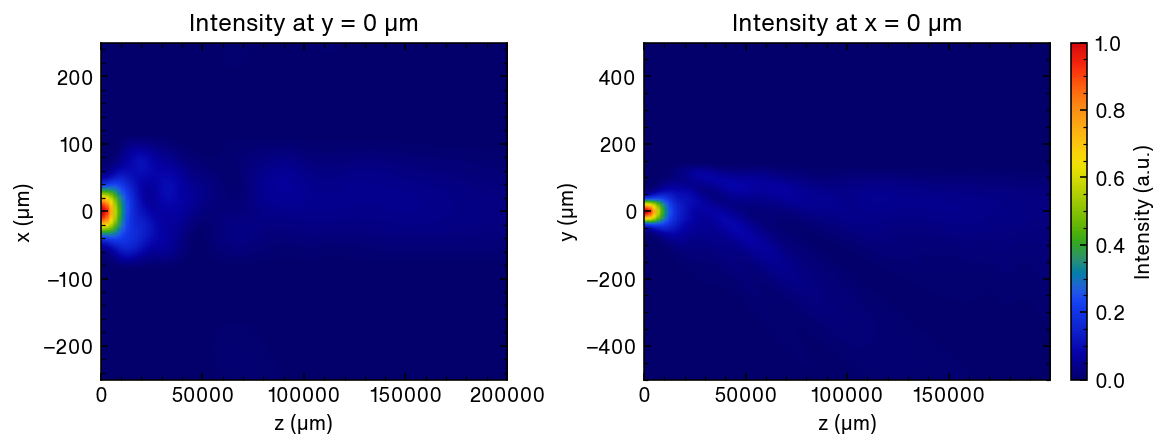

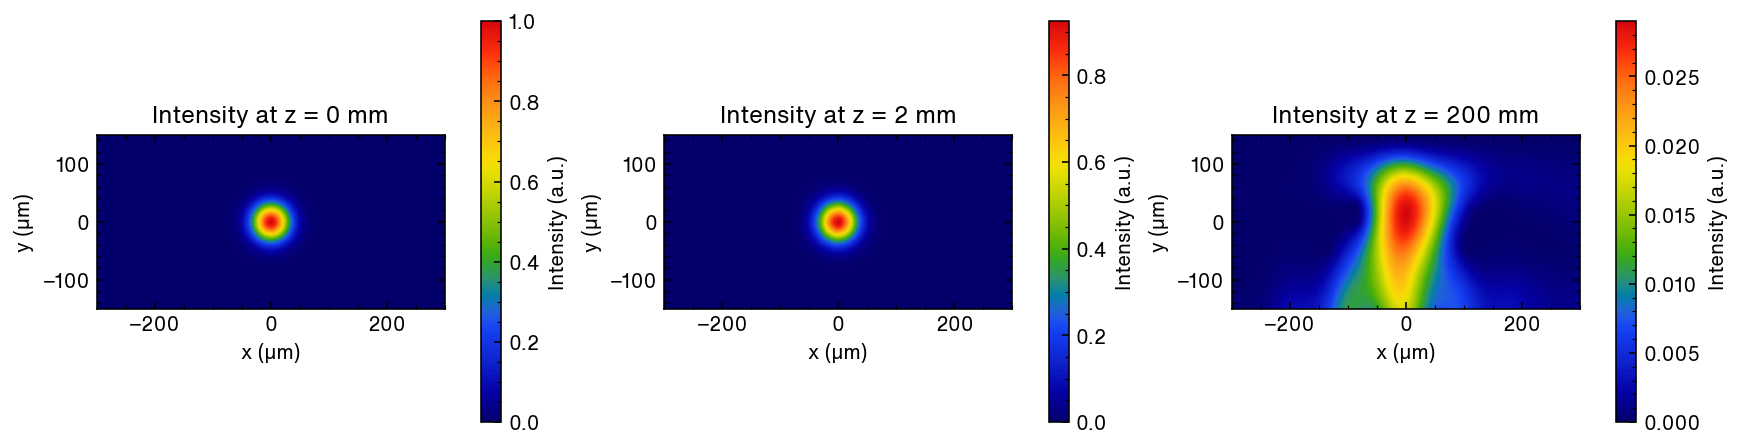

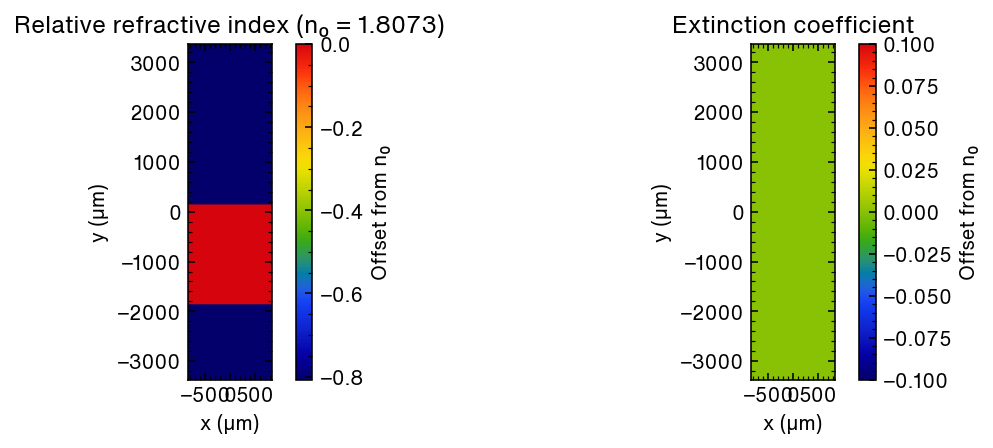

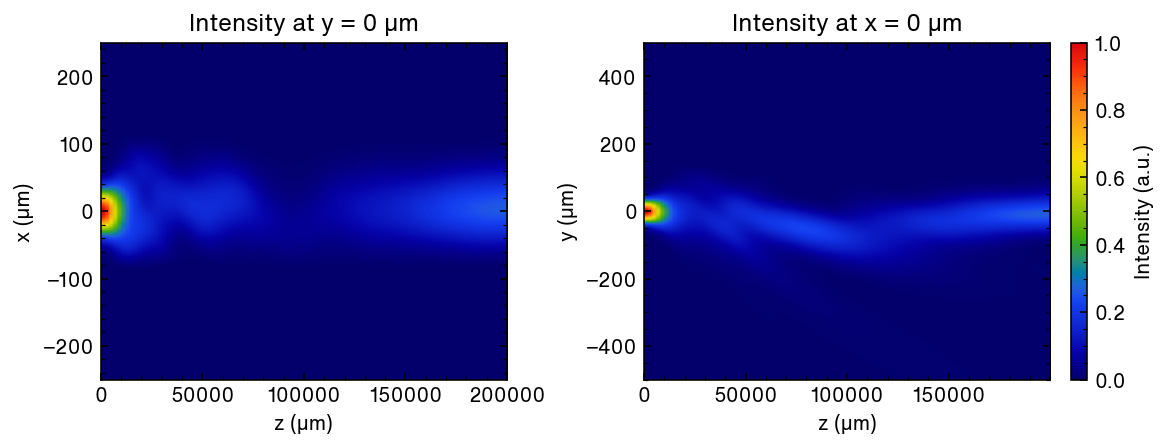

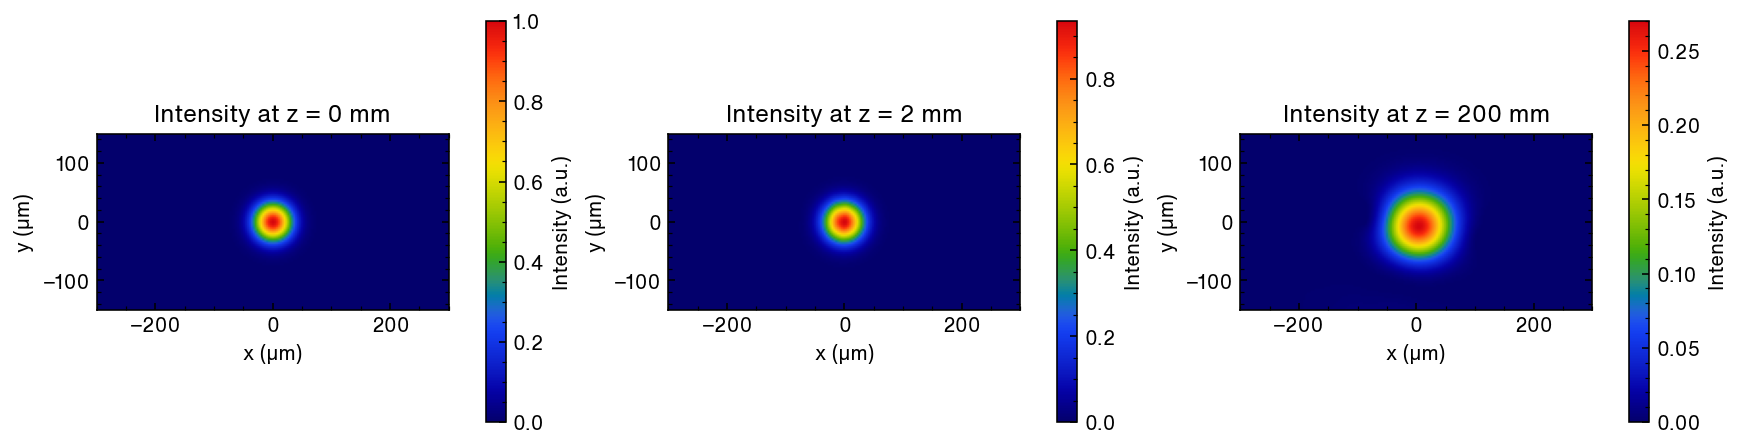

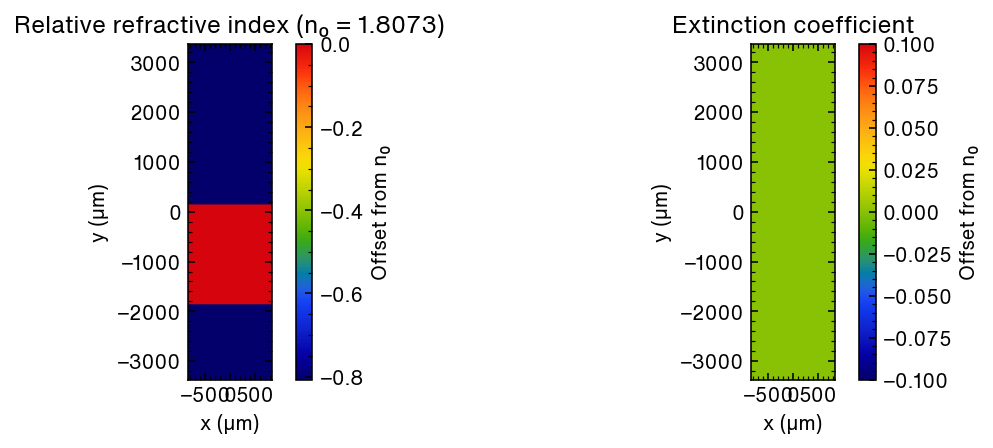

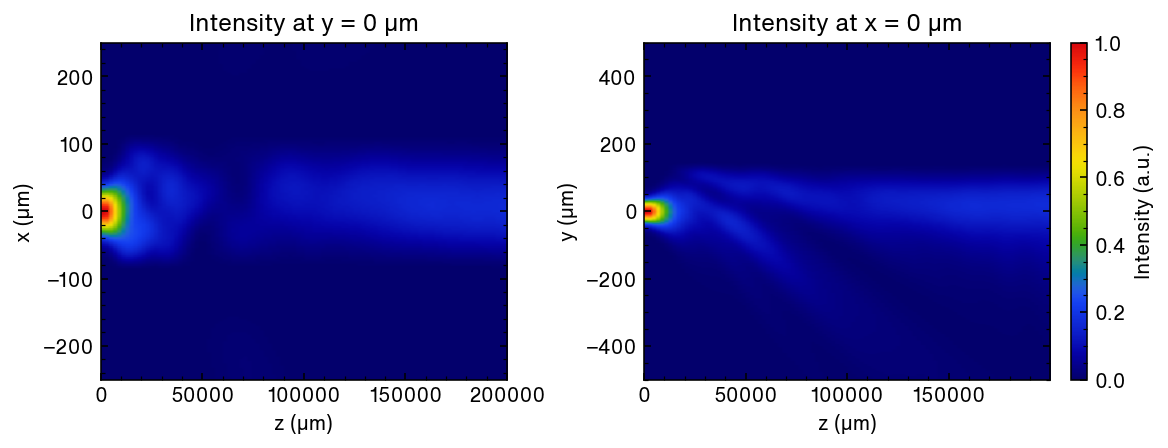

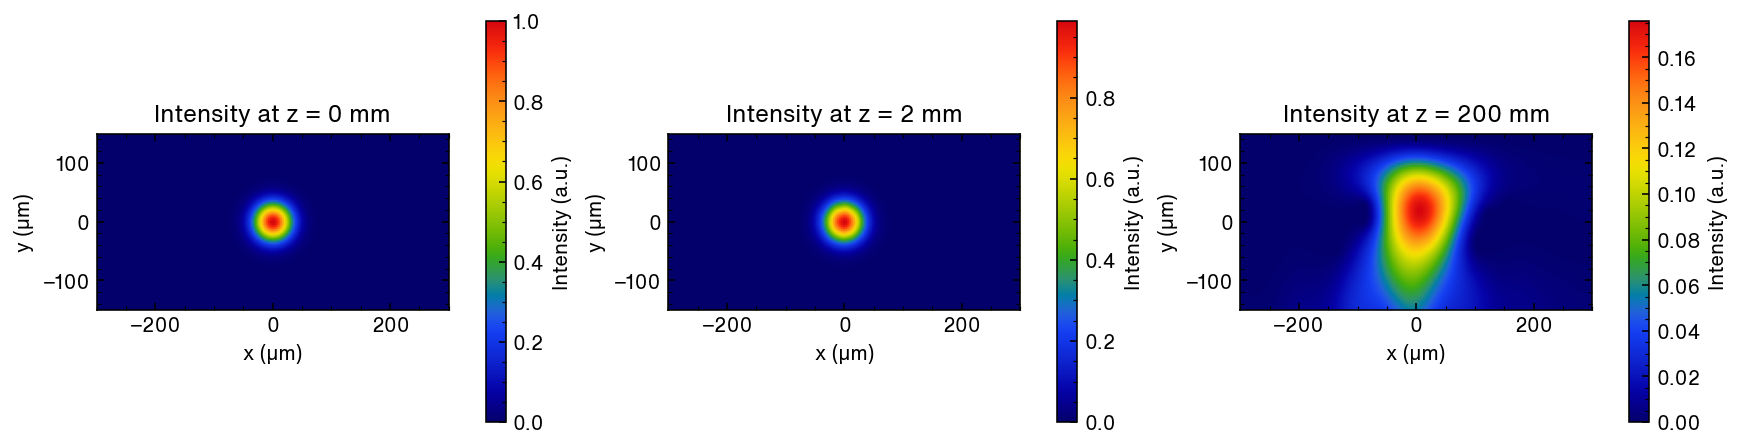

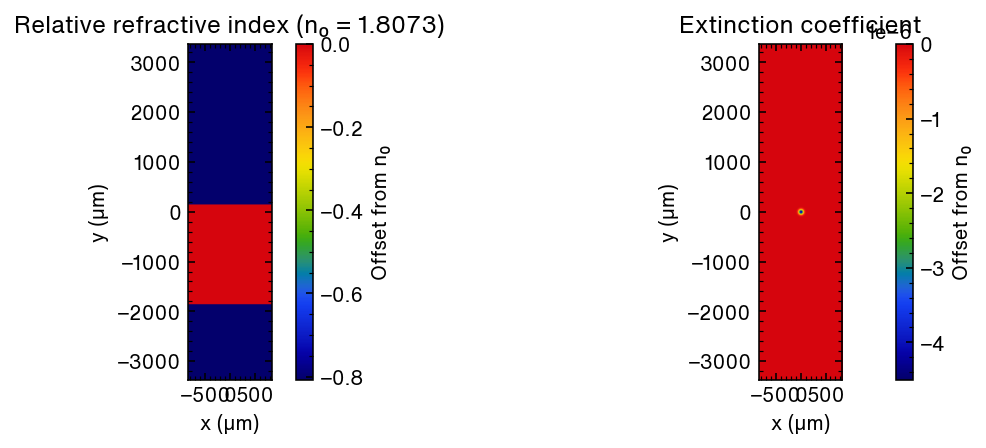

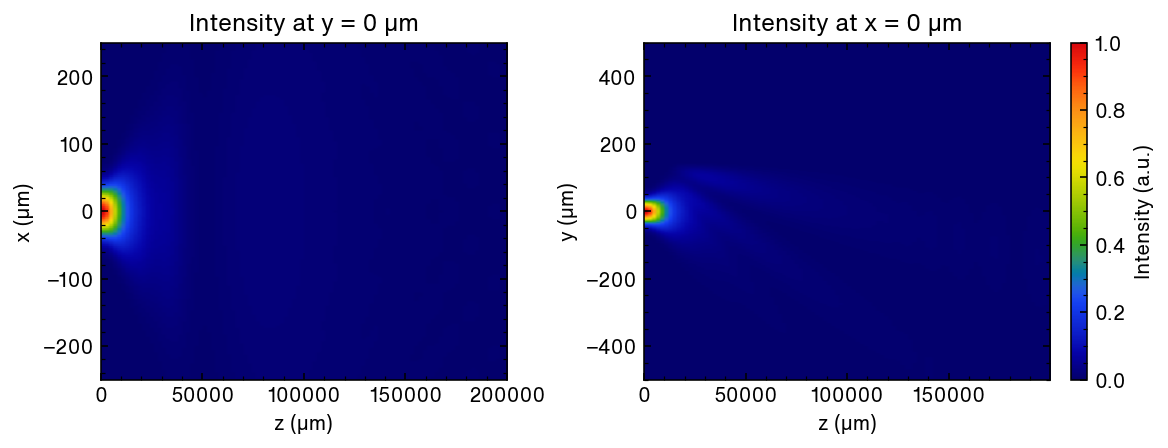

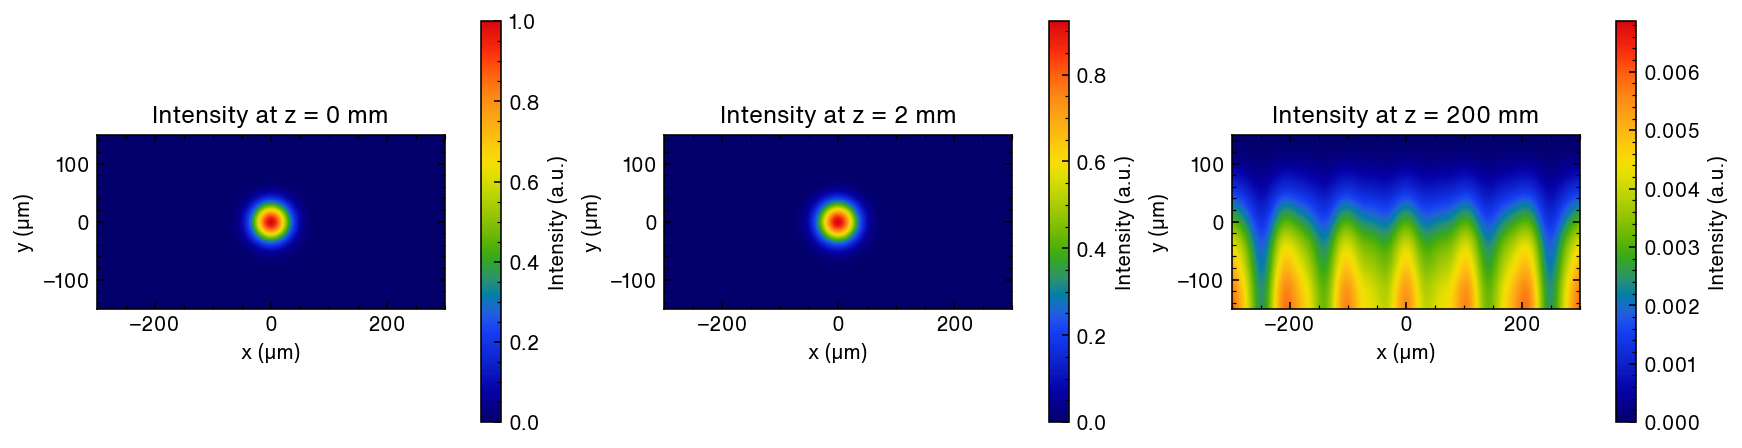

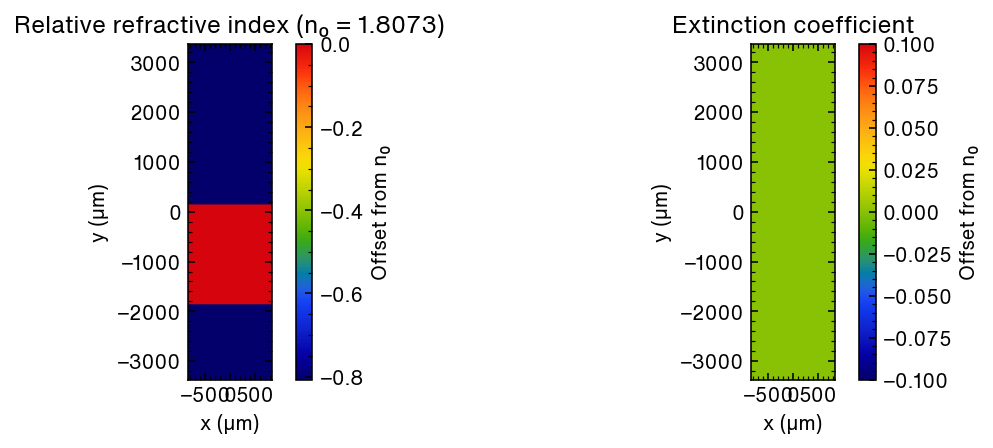

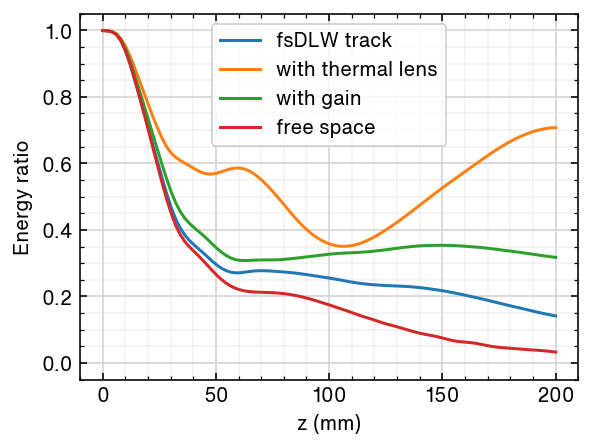

In [ ]:
# 領域サイズ
LX = 1000e-6
LY = 4000e-6
LZ = 200e-3

wavelength = 1.645e-6  # 波長
n0 = 1.8073  # 基準屈折率

# サンプリング間隔
dx = dy = wavelength * 2
dz = 20e-6

# グリッド数 (Nx, Nyは計算量削減のためにいちおう、2冪にしておく)
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)


device = torch.device("cuda:0")
item_dict = {}

beam_waist = 45e-6

save_cfolder = f"20250119_4effects_Z{round(LZ*1000)}_Bsize{round(beam_waist*1e6)}um_wl{round(wavelength*1e6, 2)}nm"
save_folder = Path.cwd() / save_cfolder
if not save_folder.exists():
    save_folder.mkdir()

delta_n = 2e-3
gc.collect()
# 入力面にガウスビームを定義 (単純化した例)
x = (torch.arange(Nx, device=device) - Nx // 2) * dx
y = (torch.arange(Ny, device=device) - Ny // 2) * dy
Y, X = torch.meshgrid(y, x, indexing="ij")

E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)

spots = 3
cl_R = 50e-6
X_interval = 250e-6
air_up, air_down = 150e-6, -1850e-6
csx, csy = -cl_R * np.cos(1 * np.pi / 4), cl_R * np.sin(1 * np.pi / 4)
# delta_n = 1e-2
# 加工領域の設定(6本)
for i in range(spots):
    ry = 20e-6
    rx = ry / 3
    cx = -(X_interval / 2 + cl_R * np.cos(i * np.pi / 4)) - csx
    cy = cl_R * np.sin(i * np.pi / 4) - csy
    mask1 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
    n_xy[mask1] = n0 - delta_n
    cx = X_interval / 2 - cl_R * np.cos(i * np.pi / 4) - csx
    cy = cl_R * np.sin(i * np.pi / 4) - csy
    mask2 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
    n_xy[mask2] = n0 - delta_n
mask0 = (Y < air_down) | (air_up < Y)
n_xy[mask0] = 1.0

# n_xy = Tlens(n_xy, npdata)
# n_xy = gain(n_xy)

Eloop = E0
for i in range(1):
    # 実行
    # 記録するZステップ位置
    iz_snap = torch.linspace(0, Nz, min(100, Nz + 1)).round().to(dtype=torch.int64)
    z_snap = dz * iz_snap
    E_snap = bpm_propagation(
        Eloop,
        Nz,
        dx,
        dy,
        dz,
        wavelength,
        n0,
        n_xy,
        iz_snap,
        diffraction_mode=DiffractionMode.PARAXIAL,
        # diffraction_mode=DiffractionMode.WIDEANGLE,
    )
    # n_xy_edge = n0 * torch.ones_like(E0, dtype=torch.complex128)
    # mask0 = (Y < air_down) | (air_up < Y)
    # n_xy_edge[mask0] = 1.0
    # Nz_edge = round(200e-6 / dz)
    # iz_snap_edge = (
    #     torch.linspace(0, Nz_edge, min(1000, Nz_edge + 1)).round().to(dtype=torch.int64)
    # )
    # z_snap = dz * iz_snap_edge
    # E_snap1 = bpm_propagation(
    #     E_snap[-1],
    #     Nz_edge,
    #     dx,
    #     dy,
    #     dz,
    #     wavelength,
    #     n0,
    #     n_xy_edge,
    #     iz_snap_edge,
    #     diffraction_mode=DiffractionMode.PARAXIAL,
    #     # diffraction_mode=DiffractionMode.WIDEANGLE,
    # )
    # Eloop = E_snap1[-1]
    # final_E_snap = E_snap1
final_E_snap = E_snap
I_snap = torch.abs(final_E_snap) ** 2

import matplotlib.pyplot as plt

ax: Axes
waveguideX, waveguideY = 300e-6, 150e-6
maskWG = (
    (X < waveguideX / 2)
    & (X > -waveguideX / 2)
    & (Y < waveguideY / 2)
    & (Y > -waveguideY / 2)
)

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min().item())
vmax = max(1, I_snap.max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = torch.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0].item() - dz / 2) * 1e6,
        (z_snap[-1].item() + dz / 2) * 1e6,
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_ylim(-250, 250)
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = torch.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0].item() * 1e6,
        z_snap[-1].item() * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylim(-500, 500)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
save_file1 = f"XZandYZ_n{delta_n:e}.png"
save_path1 = save_folder / save_file1
fig.savefig(save_path1)

vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
fig, axr = plt.subplots(1, 3, figsize=(4 * 3, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[0].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[0].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    I_snap[len(iz_snap) // 100].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[len(iz_snap) // 100].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(
    f"Intensity at z = {round(1e3 * iz_snap[len(iz_snap) // 100].item() * dz):.6g} mm"
)
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[2]
axim = ax.imshow(
    I_snap[-1].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[-1].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[-1].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

save_file2 = f"XYprofile_diffZ_n{delta_n:e}.png"
save_path2 = save_folder / save_file2
fig.savefig(save_path2)

# n_xy[~maskWG] = 1.0
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).real,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Extinction coefficient")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
save_file3 = f"nkprofile_n{delta_n:e}.png"
save_path3 = save_folder / save_file3
fig.savefig(save_path3)

energy_total = I_snap.sum(dim=(-1, -2))
I_snap_inner = I_snap.clone()
I_snap_inner[:, ~maskWG] = 0.0
energy_inner = I_snap_inner.sum(dim=(-1, -2))
item_dict["fsDLW track"] = [
    1e6 * z_snap.cpu().numpy(),
    (energy_total / energy_total[0]).cpu().numpy(),
    (energy_inner / energy_total[0]).cpu().numpy(),
]

## 熱レンズ
gc.collect()
# 入力面にガウスビームを定義 (単純化した例)
x = (torch.arange(Nx, device=device) - Nx // 2) * dx
y = (torch.arange(Ny, device=device) - Ny // 2) * dy
Y, X = torch.meshgrid(y, x, indexing="ij")
beam_waist = 45e-6
E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)

csx, csy = -cl_R * np.cos(1 * np.pi / 4), cl_R * np.sin(1 * np.pi / 4)
# delta_n = 1e-2
# 加工領域の設定(6本)
for i in range(spots):
    ry = 20e-6
    rx = ry / 3
    cx = -(X_interval / 2 + cl_R * np.cos(i * np.pi / 4)) - csx
    cy = cl_R * np.sin(i * np.pi / 4) - csy
    mask1 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
    n_xy[mask1] = n0 - delta_n
    cx = X_interval / 2 - cl_R * np.cos(i * np.pi / 4) - csx
    cy = cl_R * np.sin(i * np.pi / 4) - csy
    mask2 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
    n_xy[mask2] = n0 - delta_n
mask0 = (Y < air_down) | (air_up < Y)
n_xy[mask0] = 1.0

n_xy = Tlens(n_xy, npdata)
# n_xy = gain(n_xy)

Eloop = E0
for i in range(1):
    # 実行
    # 記録するZステップ位置
    iz_snap = torch.linspace(0, Nz, min(100, Nz + 1)).round().to(dtype=torch.int64)
    z_snap = dz * iz_snap
    E_snap = bpm_propagation(
        Eloop,
        Nz,
        dx,
        dy,
        dz,
        wavelength,
        n0,
        n_xy,
        iz_snap,
        diffraction_mode=DiffractionMode.PARAXIAL,
        # diffraction_mode=DiffractionMode.WIDEANGLE,
    )
    # n_xy_edge = n0 * torch.ones_like(E0, dtype=torch.complex128)
    # mask0 = (Y < air_down) | (air_up < Y)
    # n_xy_edge[mask0] = 1.0
    # Nz_edge = round(200e-6 / dz)
    # iz_snap_edge = (
    #     torch.linspace(0, Nz_edge, min(1000, Nz_edge + 1)).round().to(dtype=torch.int64)
    # )
    # z_snap = dz * iz_snap_edge
    # E_snap1 = bpm_propagation(
    #     E_snap[-1],
    #     Nz_edge,
    #     dx,
    #     dy,
    #     dz,
    #     wavelength,
    #     n0,
    #     n_xy_edge,
    #     iz_snap_edge,
    #     diffraction_mode=DiffractionMode.PARAXIAL,
    #     # diffraction_mode=DiffractionMode.WIDEANGLE,
    # )
    # Eloop = E_snap1[-1]
    # final_E_snap = E_snap1
final_E_snap = E_snap
I_snap = torch.abs(final_E_snap) ** 2

import matplotlib.pyplot as plt

ax: Axes
waveguideX, waveguideY = 300e-6, 150e-6
maskWG = (
    (X < waveguideX / 2)
    & (X > -waveguideX / 2)
    & (Y < waveguideY / 2)
    & (Y > -waveguideY / 2)
)

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min().item())
vmax = max(1, I_snap.max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = torch.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0].item() - dz / 2) * 1e6,
        (z_snap[-1].item() + dz / 2) * 1e6,
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_ylim(-250, 250)
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = torch.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0].item() * 1e6,
        z_snap[-1].item() * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylim(-500, 500)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
save_file1 = f"wTL_XZandYZ_n{delta_n:e}.png"
save_path1 = save_folder / save_file1
fig.savefig(save_path1)

vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
fig, axr = plt.subplots(1, 3, figsize=(4 * 3, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[0].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[0].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    I_snap[len(iz_snap) // 100].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[len(iz_snap) // 100].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(
    f"Intensity at z = {round(1e3 * iz_snap[len(iz_snap) // 100].item() * dz):.6g} mm"
)
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[2]
axim = ax.imshow(
    I_snap[-1].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[-1].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[-1].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

save_file2 = f"wTL_XYprofile_diffZ_n{delta_n:e}.png"
save_path2 = save_folder / save_file2
fig.savefig(save_path2)

# n_xy[~maskWG] = 1.0
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).real,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Extinction coefficient")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
save_file3 = f"wTL_nkprofile_n{delta_n:e}.png"
save_path3 = save_folder / save_file3
fig.savefig(save_path3)

energy_total = I_snap.sum(dim=(-1, -2))
I_snap_inner = I_snap.clone()
I_snap_inner[:, ~maskWG] = 0.0
energy_inner = I_snap_inner.sum(dim=(-1, -2))
item_dict["with thermal lens"] = [
    1e6 * z_snap.cpu().numpy(),
    (energy_total / energy_total[0]).cpu().numpy(),
    (energy_inner / energy_total[0]).cpu().numpy(),
]


## 利得
gc.collect()
# 入力面にガウスビームを定義 (単純化した例)
x = (torch.arange(Nx, device=device) - Nx // 2) * dx
y = (torch.arange(Ny, device=device) - Ny // 2) * dy
Y, X = torch.meshgrid(y, x, indexing="ij")
beam_waist = 45e-6
E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)

csx, csy = -cl_R * np.cos(1 * np.pi / 4), cl_R * np.sin(1 * np.pi / 4)
# delta_n = 1e-2
# 加工領域の設定(6本)
for i in range(spots):
    ry = 20e-6
    rx = ry / 3
    cx = -(X_interval / 2 + cl_R * np.cos(i * np.pi / 4)) - csx
    cy = cl_R * np.sin(i * np.pi / 4) - csy
    mask1 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
    n_xy[mask1] = n0 - delta_n
    cx = X_interval / 2 - cl_R * np.cos(i * np.pi / 4) - csx
    cy = cl_R * np.sin(i * np.pi / 4) - csy
    mask2 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
    n_xy[mask2] = n0 - delta_n
mask0 = (Y < air_down) | (air_up < Y)
n_xy[mask0] = 1.0

# n_xy = Tlens(n_xy, npdata)
n_xy = gain(n_xy)

Eloop = E0
for i in range(1):
    # 実行
    # 記録するZステップ位置
    iz_snap = torch.linspace(0, Nz, min(100, Nz + 1)).round().to(dtype=torch.int64)
    z_snap = dz * iz_snap
    E_snap = bpm_propagation(
        Eloop,
        Nz,
        dx,
        dy,
        dz,
        wavelength,
        n0,
        n_xy,
        iz_snap,
        diffraction_mode=DiffractionMode.PARAXIAL,
        # diffraction_mode=DiffractionMode.WIDEANGLE,
    )
    # n_xy_edge = n0 * torch.ones_like(E0, dtype=torch.complex128)
    # mask0 = (Y < air_down) | (air_up < Y)
    # n_xy_edge[mask0] = 1.0
    # Nz_edge = round(200e-6 / dz)
    # iz_snap_edge = (
    #     torch.linspace(0, Nz_edge, min(1000, Nz_edge + 1)).round().to(dtype=torch.int64)
    # )
    # z_snap = dz * iz_snap_edge
    # E_snap1 = bpm_propagation(
    #     E_snap[-1],
    #     Nz_edge,
    #     dx,
    #     dy,
    #     dz,
    #     wavelength,
    #     n0,
    #     n_xy_edge,
    #     iz_snap_edge,
    #     diffraction_mode=DiffractionMode.PARAXIAL,
    #     # diffraction_mode=DiffractionMode.WIDEANGLE,
    # )
    # Eloop = E_snap1[-1]
    # final_E_snap = E_snap1
final_E_snap = E_snap
I_snap = torch.abs(final_E_snap) ** 2

import matplotlib.pyplot as plt

ax: Axes
waveguideX, waveguideY = 300e-6, 150e-6
maskWG = (
    (X < waveguideX / 2)
    & (X > -waveguideX / 2)
    & (Y < waveguideY / 2)
    & (Y > -waveguideY / 2)
)

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min().item())
vmax = max(1, I_snap.max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = torch.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0].item() - dz / 2) * 1e6,
        (z_snap[-1].item() + dz / 2) * 1e6,
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_ylim(-250, 250)
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = torch.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0].item() * 1e6,
        z_snap[-1].item() * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylim(-500, 500)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
save_file1 = f"wgain_XZandYZ_n{delta_n:e}.png"
save_path1 = save_folder / save_file1
fig.savefig(save_path1)

vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
fig, axr = plt.subplots(1, 3, figsize=(4 * 3, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[0].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[0].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    I_snap[len(iz_snap) // 100].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[len(iz_snap) // 100].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(
    f"Intensity at z = {round(1e3 * iz_snap[len(iz_snap) // 100].item() * dz):.6g} mm"
)
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[2]
axim = ax.imshow(
    I_snap[-1].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[-1].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[-1].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

save_file2 = f"wgain_XYprofile_diffZ_n{delta_n:e}.png"
save_path2 = save_folder / save_file2
fig.savefig(save_path2)

# n_xy[~maskWG] = 1.0
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).real,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Extinction coefficient")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
save_file3 = f"wgain_nkprofile_n{delta_n:e}.png"
save_path3 = save_folder / save_file3
fig.savefig(save_path3)

energy_total = I_snap.sum(dim=(-1, -2))
I_snap_inner = I_snap.clone()
I_snap_inner[:, ~maskWG] = 0.0
energy_inner = I_snap_inner.sum(dim=(-1, -2))
item_dict["with gain"] = [
    1e6 * z_snap.cpu().numpy(),
    (energy_total / energy_total[0]).cpu().numpy(),
    (energy_inner / energy_total).cpu().numpy(),  # 常に利得を得て増加していくので
]


## 何も加工していない
gc.collect()
# 入力面にガウスビームを定義 (単純化した例)
x = (torch.arange(Nx, device=device) - Nx // 2) * dx
y = (torch.arange(Ny, device=device) - Ny // 2) * dy
Y, X = torch.meshgrid(y, x, indexing="ij")
beam_waist = 45e-6
E0 = torch.exp(-(X**2 + Y**2) / (beam_waist**2)).to(dtype=torch.complex128)

# z方向に均一な屈折率分布 (例: コア円形領域)
n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)

csx, csy = -cl_R * np.cos(1 * np.pi / 4), cl_R * np.sin(1 * np.pi / 4)
# delta_n = 1e-2
# 加工領域の設定(6本)
# for i in range(spots):
#     ry = 20e-6
#     rx = ry / 3
#     cx = -(X_interval / 2 + cl_R * np.cos(i * np.pi / 4)) - csx
#     cy = cl_R * np.sin(i * np.pi / 4) - csy
#     mask1 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
#     n_xy[mask1] = n0 - delta_n
#     cx = X_interval / 2 - cl_R * np.cos(i * np.pi / 4) - csx
#     cy = cl_R * np.sin(i * np.pi / 4) - csy
#     mask2 = ((X - cx) / rx) ** 2 + ((Y - cy) / ry) ** 2 < 1
#     n_xy[mask2] = n0 - delta_n
mask0 = (Y < air_down) | (air_up < Y)
n_xy[mask0] = 1.0

# n_xy = Tlens(n_xy, npdata)
# n_xy = gain(n_xy)

Eloop = E0
for i in range(1):
    # 実行
    # 記録するZステップ位置
    iz_snap = torch.linspace(0, Nz, min(100, Nz + 1)).round().to(dtype=torch.int64)
    z_snap = dz * iz_snap
    E_snap = bpm_propagation(
        Eloop,
        Nz,
        dx,
        dy,
        dz,
        wavelength,
        n0,
        n_xy,
        iz_snap,
        diffraction_mode=DiffractionMode.PARAXIAL,
        # diffraction_mode=DiffractionMode.WIDEANGLE,
    )
    # n_xy_edge = n0 * torch.ones_like(E0, dtype=torch.complex128)
    # mask0 = (Y < air_down) | (air_up < Y)
    # n_xy_edge[mask0] = 1.0
    # Nz_edge = round(200e-6 / dz)
    # iz_snap_edge = (
    #     torch.linspace(0, Nz_edge, min(1000, Nz_edge + 1)).round().to(dtype=torch.int64)
    # )
    # z_snap = dz * iz_snap_edge
    # E_snap1 = bpm_propagation(
    #     E_snap[-1],
    #     Nz_edge,
    #     dx,
    #     dy,
    #     dz,
    #     wavelength,
    #     n0,
    #     n_xy_edge,
    #     iz_snap_edge,
    #     diffraction_mode=DiffractionMode.PARAXIAL,
    #     # diffraction_mode=DiffractionMode.WIDEANGLE,
    # )
    # Eloop = E_snap1[-1]
    # final_E_snap = E_snap1
final_E_snap = E_snap
I_snap = torch.abs(final_E_snap) ** 2

import matplotlib.pyplot as plt

ax: Axes
waveguideX, waveguideY = 300e-6, 150e-6
maskWG = (
    (X < waveguideX / 2)
    & (X > -waveguideX / 2)
    & (Y < waveguideY / 2)
    & (Y > -waveguideY / 2)
)

cmap = "cet_rainbow4"  # %pip install colorcet; import colorcet

vmin = min(0, I_snap.min().item())
vmax = max(1, I_snap.max().item())
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
iyc = torch.searchsorted(y, 0.0)
axim = ax.imshow(
    I_snap[:, iyc, :].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        (z_snap[0].item() - dz / 2) * 1e6,
        (z_snap[-1].item() + dz / 2) * 1e6,
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylabel("x (µm)")
ax.set_ylim(-250, 250)
ax.set_title(f"Intensity at y = {1e6 * y[iyc]:.6g} µm")
ax = axr[1]
ixc = torch.searchsorted(x, 0.0)
axim = ax.imshow(
    I_snap[:, :, ixc].T.cpu().numpy(),
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=(
        z_snap[0].item() * 1e6,
        z_snap[-1].item() * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=vmin,
    vmax=vmax,
)
ax.set_ylim(-500, 500)
ax.set_ylabel("y (µm)")
ax.set_title(f"Intensity at x = {1e6 * x[ixc]:.6g} µm")
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("z (µm)")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
save_file1 = f"NO_XZandYZ_n{delta_n:e}.png"
save_path1 = save_folder / save_file1
fig.savefig(save_path1)

vmin = min(0, I_snap[0].min().item(), I_snap[-1].min().item())
vmax = max(1, I_snap[0].max().item(), I_snap[-1].max().item())
fig, axr = plt.subplots(1, 3, figsize=(4 * 3, 3))
ax = axr[0]
axim = ax.imshow(
    I_snap[0].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[0].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[0].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    I_snap[len(iz_snap) // 100].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[len(iz_snap) // 100].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(
    f"Intensity at z = {round(1e3 * iz_snap[len(iz_snap) // 100].item() * dz):.6g} mm"
)
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
ax = axr[2]
axim = ax.imshow(
    I_snap[-1].cpu().numpy(),
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
    vmin=0,
    vmax=I_snap[-1].max().item(),
)
ax.set_xlim(-waveguideX * 1e6, waveguideX * 1e6)
ax.set_ylim(-waveguideY * 1e6, waveguideY * 1e6)
ax.set_title(f"Intensity at z = {round(1e3 * iz_snap[-1].item() * dz):.6g} mm")
cbar = fig.colorbar(axim, label="Intensity (a.u.)")
cbar.minorticks_on()
for ax in axr:
    ax.minorticks_on()
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

save_file2 = f"NO_XYprofile_diffZ_n{delta_n:e}.png"
save_path2 = save_folder / save_file2
fig.savefig(save_path2)

# n_xy[~maskWG] = 1.0
fig, axr = plt.subplots(1, 2, figsize=(4 * 2, 3))
ax = axr[0]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).real,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Relative refractive index (n₀ = {n0:.6g})")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
ax = axr[1]
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
axim = ax.imshow(
    (n_xy.cpu().numpy() - n0).imag,
    cmap=cmap,
    origin="lower",
    # aspect="auto",
    extent=(
        (x[0].item() - dx / 2) * 1e6,
        (x[-1].item() + dx / 2) * 1e6,
        (y[0].item() - dy / 2) * 1e6,
        (y[-1].item() + dy / 2) * 1e6,
    ),
)
ax.set_title(f"Extinction coefficient")
ax.minorticks_on()
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
cbar = fig.colorbar(axim, label="Offset from n₀")
cbar.minorticks_on()
save_file3 = f"NO_nkprofile_n{delta_n:e}.png"
save_path3 = save_folder / save_file3
fig.savefig(save_path3)

energy_total = I_snap.sum(dim=(-1, -2))
I_snap_inner = I_snap.clone()
I_snap_inner[:, ~maskWG] = 0.0
energy_inner = I_snap_inner.sum(dim=(-1, -2))
item_dict["free space"] = [
    1e6 * z_snap.cpu().numpy(),
    (energy_total / energy_total[0]).cpu().numpy(),
    (energy_inner / energy_total[0]).cpu().numpy(),
]


fig, ax = plt.subplots()
for key in item_dict.keys():
    # ax.plot(
    #     item_dict[key][0] * 1e-3,
    #     item_dict[key][1],
    #     label=r"Total $\Delta$ n=" + str(key),
    # )
    ax.plot(
        item_dict[key][0] * 1e-3,
        item_dict[key][2],
        label=str(key),
    )
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (mm)")
ax.set_ylabel("Energy ratio")
save_path4 = save_folder / "energy_ratio.png"
fig.savefig(save_path4)

# akiyama

### def

In [256]:
from enum import StrEnum

import torch
from torch.fft import fft2, ifft2, fftfreq
from tqdm.auto import trange


class DiffractionMode(StrEnum):
    PARAXIAL = "paraxial"
    """θ<~ 10°; 計算が安定"""
    WIDEANGLE = "wideangle"
    """θ<~ 25°; dxとdyが小さすぎると屈折率虚数で高周波成分が壊れる"""

def bpm_propagation(
    E0: torch.Tensor,  # torch.Tensor[torch.complex128]
    z_steps: int,
    dx: float,
    dy: float,
    dz: float,
    wavelength: float,
    n0: float,
    n_xy: torch.Tensor,  # torch.Tensor[torch.float64]
    iz_snap: torch.Tensor,  # torch.Tensor[torch.int64]
    diffraction_mode: DiffractionMode = DiffractionMode.PARAXIAL,
) -> torch.Tensor:  # torch.Tensor[torch.complex128]
    """
    近軸近似に基づくスプリットステップBPMによるビーム伝搬を行う。

    Parameters
    ----------
    E0 : torch.Tensor[torch.complex128]
        z=0 の (x,y) 平面上の複素振幅分布 (Nx, Ny)
    z_steps : int
        z方向のステップ数
    dx, dy : float
        x, y, z 方向の空間サンプリング間隔 [m]
    wavelength : float
        真空中の波長 [m]
    n0 : float
        基準屈折率（全体の平均的な屈折率など）
    n_xy : torch.Tensor[np.float64]
        (x,y) 平面上の屈折率分布 (Nx, Ny)
        ここでは z方向に均一(=変化なし)と仮定している。
    iz_snap: torch.Tensor[np.int64]
        Eのスナップショットをとるステップ番号のリスト (0 <= iz <= z_steps)

    Returns
    -------
    E_snap : torch.Tensor[np.complex128]
        z = iz_snap * dz の平面での複素振幅分布 (*iz_snap.shape, Nx, Ny)
    """
    # --- 基本定数等の準備 ---
    # 真空中の波数 k0 = 2π / λ
    k0 = 2.0 * torch.pi / wavelength

    # --- 入力場をコピーして伝搬の計算に使う ---
    E = E0.clone()

    Nx, Ny = E.shape

    # 周波数領域の格子ベクトル (kx, ky)
    # fftfreq(N, d=Δx) は -1/(2Δx) 〜 +1/(2Δx) の範囲で周波数を生成
    kx: torch.Tensor = 2.0 * torch.pi * fftfreq(Nx, d=dx, device=E.device)
    ky: torch.Tensor = 2.0 * torch.pi * fftfreq(Ny, d=dy, device=E.device)
    # メッシュグリッド (KX, KY) (Nx, Ny)
    KX, KY = torch.meshgrid(kx, ky, indexing="ij")

    match diffraction_mode:
        case DiffractionMode.PARAXIAL:
            # --- フーリエ領域での回折項 (パラキシアル近似) ---
            #   H = exp( -i * (kx^2 + ky^2) / (2 * k0 * n0) * dz )
            #   これが各 zステップごとの回折演算に対応する
            H: torch.Tensor = torch.exp(-1j * (KX**2 + KY**2) / (2.0 * k0 * n0) * dz)
        case DiffractionMode.WIDEANGLE:
            # --- "広角" (semi-paraxial) 回折演算子 (Fourierドメイン)
            #     kz(kx, ky) = sqrt((k0*n0)^2 - (kx^2 + ky^2))
            #     伝搬演算子 = exp( -i [ kz - k0 n0 ] dz )
            kz: torch.Tensor = torch.sqrt((k0 * n0) ** 2 - (KX**2 + KY**2))
            H: torch.Tensor = torch.exp(1j * (kz - k0 * n0) * dz)
        case _:
            raise NotImplementedError

    # --- 屈折率による位相変調 (z方向に均一: n_xy は常に同じ) ---
    #   φ = k0 * (n_xy - n0) * dz
    #   z方向に均一なら毎ステップ同じ位相を掛けるだけ
    phase_term: torch.Tensor = torch.exp(1j * k0 * (n_xy - n0) * dz)

    E_snap = torch.zeros((*iz_snap.shape, *E.shape), dtype=E.dtype, device=E.device)
    E_snap[torch.nonzero(iz_snap == 0)] = E

    # --- スプリットステップループ ---
    for iz in trange(z_steps):
        # 1) 回折項 (Fourierドメインで位相を掛ける)
        E_f = fft2(E)
        E_f *= H
        E = ifft2(E_f)

        # 2) 屈折率分布による位相変化を実空間で掛ける
        E *= phase_term

        # 保存
        E_snap[torch.nonzero(iz_snap == iz + 1)] = E

    return E_snap

def get_xz_on_triangle(i: int,
                       divisions: int,
                       base_center: tuple,
                       height: float,
                       base_length: float,
                       f: float) -> tuple:
    """XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    
    Parameters
    ----------
    i : int
        取得したい点のインデックス (0 ≤ i < 2*divisions)
    divisions : int
        一つの等辺を何分割するか。各等辺上に分割数だけ点が並びます。
    base_center : tuple
        底辺（x軸平行）の中心位置。(x, z)の形で渡します。
    height : float
        底辺から頂点までの高さ（物理長さ）。Z方向の移動時はこの値をfで割って使用します。
    base_length : float
        底辺の長さ（物理長さ）。
    f : 意味のない値
    
    Returns
    -------
    tuple
        書き込みを行うべきX,Z座標を返します。
    """
    # 底辺の両端
    half_base = base_length / 2
    left_x, left_z   = base_center[0] - half_base, base_center[1]
    right_x, right_z = base_center[0] + half_base, base_center[1]

    # 頂点（Z方向はスケール補正）
    apex_x = base_center[0]
    apex_z = base_center[1] + height

    total_pts = divisions * 2
    assert 0 <= i < total_pts, "i must be in [0, 2*divisions)"

    # i < divisions のときは「左辺 (左底辺→頂点)」、
    # それ以外は「右辺 (右底辺→頂点)」を扱う
    if i < divisions:
        # 左辺の j = 1 .. divisions
        j = i + 1
        frac = j / divisions
        x = left_x + frac * half_base
        z = left_z + frac * height
    else:
        # 右辺の j = 1 .. divisions
        j = (i - divisions) + 1
        frac = j / divisions
        x = right_x - frac * half_base
        z = right_z + frac * height

    return (x, z)


def get_xz_on_circle(i: int,
                       divisions: int,
                       base_center: tuple,
                       raidus: float,
                       ) -> tuple:
    """XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    
    Parameters
    ----------
    i : int
        取得したい点のインデックス (0 ≤ i < 2*divisions)
    divisions : int
        一つの等辺を何分割するか。各等辺上に分割数だけ点が並びます。
    base_center : tuple
        円の中心位置。(x, z)の形で渡します。
    radius : float
    
    Returns
    -------
    tuple
        書き込みを行うべきX,Z座標を返します。
    """
    interval= np.pi*2 / divisions 
    assert 0 <= i < divisions, "i must be in [0, 2*divisions)"
    x= base_center[0] + radius* np.cos(interval* i)
    z= base_center[1] + radius* np.sin(interval* i)

    return (x, z)

#####################################################
# 1. 書き込みを行った座標に屈折率変化を与える関数
#####################################################

def ndown(
    n_xy: torch.Tensor,
    wxc: float,
    wyc: float,
    bwx: float,
    bwy: float,
    na: float,
    X: torch.Tensor,
    Y: torch.Tensor
) -> torch.Tensor:
    """
    ガウス分布で屈折率変化を付与する(屈折率を減少/増加させる)
    n_xy : 屈折率分布
    wxc, wyc : 変化中心座標
    bwx, bwy : ガウス分布の幅
    na       : ピーク値 (マイナスの値なら屈折率減少)
    X, Y     : メッシュグリッド
    """
    # 例: 屈折率が na だけ増減するガウス分布を加算
    #     ガウスの形状は exp(-(2*(X-wxc)^2 / bwx^2 + 2*(Y-wyc)^2 / bwy^2))
    # ここでは n_xy += ... として書き込みを行う
    gaus = na * torch.exp(
        -(
            2.0 * (X - wxc) ** 2 / (bwx**2)
            + 2.0 * (Y - wyc) ** 2 / (bwy**2)
        )
    )
    n_xy += gaus.to(dtype=torch.complex128)
    return n_xy

import torch
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

def plot_y_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    cmap: str = "cet_rainbow4",
    ax: Axes = None,
    x_range: tuple = (-250, 250),
    vmin: float = None,
    vmax: float = None,
    k: float =0
):
    """
    y=0付近の断面 (x-z面) の強度分布を imshow で表示する。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        形状: [len(z_snap), Ny, Nx]
        BPM計算後の各zステップでの強度(=|E|^2)データ
    x, y : torch.Tensor
        x, y座標配列 (1次元)
    z_snap : torch.Tensor
        取得したzステップ (m単位)
    dx, dy, dz : float
        x, y, z方向のサンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes。指定がなければ新規作成
    x_range : tuple
        x方向の表示範囲 (µm単位)
    vmin, vmax : float
        カラースケールの最小値・最大値 (強度)
    k : yをいくつで切断するか
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    # y=0に最も近いインデックスを探す
    iyc = torch.searchsorted(y, torch.tensor(k))
    # shape: [len(z_snap), Nx] -> 転置後 [Nx, len(z_snap)]
    I_xz = I_snap[:, iyc, :].T.cpu().numpy()

    # 物理座標範囲を µm 単位で設定
    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6

    # vmin, vmax が未指定なら自動またはデータに応じて設定
    if vmin is None:
        vmin = min(0, I_xz.min())
    if vmax is None:
        vmax = max(1, I_xz.max())

    im = ax.imshow(
        I_xz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, x_min, x_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("x (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(*x_range)
    ax.set_title(f"Intensity at y=0 (iy={iyc})")

    # カラーバーを付ける場合
    # plt.colorbar(im, ax=ax, label="Intensity (a.u.)")

    return im


def plot_x_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    cmap: str = "cet_rainbow4",
    ax: Axes = None,
    y_range: tuple = (-500, 500),
    vmin: float = None,
    vmax: float = None
):
    """
    x=0付近の断面 (y-z面) の強度分布を imshow で表示する。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        [len(z_snap), Ny, Nx] 形状の強度データ
    x, y : torch.Tensor
        x, y座標配列 (1次元)
    z_snap : torch.Tensor
        zステップ配列
    dx, dy, dz : float
        サンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes
    y_range : tuple
        y方向の表示範囲 (µm)
    vmin, vmax : float
        カラースケールの最小値・最大値
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    # x=0に最も近いインデックスを探す
    ixc = torch.searchsorted(x, torch.tensor(0.0))
    # shape: [len(z_snap), Ny] -> 転置後 [Ny, len(z_snap)]
    I_yz = I_snap[:, :, ixc].T.cpu().numpy()

    z_min, z_max = z_snap[0].item()*1e6, z_snap[-1].item()*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    if vmin is None:
        vmin = min(0, I_yz.min())
    if vmax is None:
        vmax = max(1, I_yz.max())

    im = ax.imshow(
        I_yz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("y (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(*y_range)
    ax.set_title(f"Intensity at x=0 (ix={ixc})")

    return im


def plot_z_slice(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    idx_z: int,
    dx: float,
    dy: float,
    cmap: str = "cet_rainbow4",
    ax: Axes = None,
    x_range: tuple = None,
    y_range: tuple = None,
    title: str = None,
    vmin: float = None,
    vmax: float = None
):
    """
    指定したzインデックスの断面 (x-y平面) をプロットする。
    
    Parameters
    ----------
    I_snap : torch.Tensor
        形状: [len(z_snap), Ny, Nx] の強度データ
    x, y : torch.Tensor
        x, y座標配列
    idx_z : int
        何番目のzスナップを可視化するか
    dx, dy : float
        サンプリング間隔
    cmap : str
        カラーマップ
    ax : matplotlib.axes.Axes
        描画先のAxes (指定がなければ新規作成)
    x_range, y_range : tuple
        x, yそれぞれの表示範囲 (µm単位) (例: (-300,300))
    title : str
        描画する際のタイトル
    vmin, vmax : float
        カラースケールの最小値・最大値
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    I_xy = I_snap[idx_z, :, :].cpu().numpy()

    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = I_xy.max()

    im = ax.imshow(
        I_xy,
        cmap=cmap,
        origin="lower",
        extent=(x_min, x_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )

    if x_range is not None:
        ax.set_xlim(*x_range)
    if y_range is not None:
        ax.set_ylim(*y_range)
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

    if title is not None:
        ax.set_title(title)

    return im


import torch
import matplotlib.pyplot as plt
import io
import imageio
import numpy as np
from PIL import Image, ImageSequence

def create_gif_animation(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    dx: float,
    dy: float,
    z_snap: torch.Tensor,
    gif_filename: str,
    fps: int = 10,
    cmap: str = "cet_rainbow4",
    x_range: tuple = None,
    y_range: tuple = None,
    bunkatsu=10
):
    """
    I_snap 内の全z断面 (あるいは一部) を順番にプロットしてGIFアニメを作成。

    Parameters
    ----------
    I_snap : (nZ, Ny, Nx) の強度分布
    x, y   : 1D座標配列
    dx, dy : [m] サンプリング間隔
    z_snap : [nZ] zステップ配列 (m)
    gif_filename : 出力GIFのファイル名
    fps : GIFのフレームレート
    cmap : カラーマップ
    x_range, y_range : 表示範囲 (µm単位)
    """
    import io
    import imageio

    images = []
    nZ = I_snap.shape[0]

    # vmin, vmax を全断面で合わせたい場合は先に求めておく
    # (必要なければ各断面で自動的に決めてもOK)
    global_min = float(I_snap.min())
    global_max = float(I_snap.max())
    # あるいは 0 ~ max などに固定
    vmin, vmax = 0, global_max

    for idx_z in range(nZ):
        if idx_z% bunkatsu==0:
            z_mm = z_snap[idx_z].item() * 1e3  # mm単位
            title_str = f"z = {z_mm:.3f} mm"

            # Figureを作って描画
            fig, ax = plt.subplots(figsize=(4,3))
            plot_z_slice(
                I_snap,
                x, y,
                idx_z,
                dx, dy,
                cmap=cmap,
                x_range=x_range,
                y_range=y_range,
                title=title_str,
                vmin=vmin,
                vmax=vmax,
                ax=ax
            )
            
            # カラーバーを追加したい場合
            # imshowの戻り値を受け取って colorbar へ
            # ただし plot_z_slice() から返した im を受け取るようにするなど工夫が必要
            # ここでは簡単のため割愛

            # 図を一時的にメモリ上へ保存
            buf = io.BytesIO()
            plt.savefig(buf, format="png", dpi=100)
            plt.close(fig)  # 使い終わったFigureは閉じる

            buf.seek(0)
            # 画像として読み込み
            img = imageio.v2.imread(buf)
            images.append(img)

    # GIFで保存
    imageio.mimsave(gif_filename, images, fps=fps, loop=0)
    print(f"GIF saved to {gif_filename}")

## triangle

In [ ]:
import torch
import math

###############################
# 前提: 以下の変数・配列が既に定義されていると仮定
###############################
# - X, Y  : 2次元メッシュグリッド (shapeは [Nx, Ny])。単位は [m]
#           例) x = torch.linspace(-200e-6, 200e-6, Nx)
#                y = torch.linspace(-200e-6, 200e-6, Ny)
#                X, Y = torch.meshgrid(x, y, indexing='ij')
# - beam_waist : トップハットの半径に相当する値 [m]
# - NA         : フィルタリングに用いる数値開口
# - lambda0    : 中心波長 [m] (例: 793e-9)
#
# ここでは各変数が既に与えられているものとして、初期電場 E0 を作る処理のみ書きます。
###############################

# --- 1. トップハット型強度分布を作成 ---
#     コア径程度を想定して「(X^2 + (Y - y0)^2) < beam_waist^2」を満たす領域を振幅1、それ以外を0とする。
#     ここでは y0 = 100e-6 の位置を中心にしています。
top_hat_mask = ((X**2 + (Y - 100e-6)**2) < (beam_waist**2)).to(torch.float64)

# --- 2. 一様ランダム位相を付与 ---
#     各画素（メッシュ点）に対し、[0, 2π) の位相を乱数で割り当てる。
random_phase = 2 * math.pi * torch.rand_like(X, dtype=torch.float64)
# 複素場 (complex128) で表現。まずはfloat64で作り、あとでcomplex128に変換してもOK。
E_random = top_hat_mask * torch.exp(1j * random_phase)

# --- 3. 2次元FFTで周波数空間へ変換 ---
E_fft = torch.fft.fftn(E_random)

# --- 4. 空間周波数フィルタ (NAカット) を適用 ---
#     NA = 0.1 などを想定。k0 = 2π / λ
Nx, Ny = X.shape
dx = (X[1, 0] - X[0, 0]).item()  # X方向メッシュピッチ
dy = (Y[0, 1] - Y[0, 0]).item()  # Y方向メッシュピッチ

kx = 2 * math.pi * torch.fft.fftfreq(Nx, d=dx, dtype=torch.float64)
ky = 2 * math.pi * torch.fft.fftfreq(Ny, d=dy, dtype=torch.float64)

KX, KY = torch.meshgrid(kx, ky, indexing='ij')
k_radius = torch.sqrt(KX**2 + KY**2)

k0 = 2 * math.pi / lambda0        # 真空中波数
k_cut = k0 * NA                   # NAに対応した最大空間周波数

# 半径 k_cut を超える成分をカット
filter_mask = (k_radius < k_cut)
E_fft_filtered = E_fft * filter_mask

# --- 5. 逆FFTで空間領域に戻す ---
E_filtered = torch.fft.ifftn(E_fft_filtered)

# --- 6. パワー規格化 (オプション) ---
#     フィルタ適用前と同じ総パワーに合わせたい場合など
power_before = (E_random.abs()**2).sum()
power_after  = (E_filtered.abs()**2).sum()
scale_factor = torch.sqrt(power_before / power_after)
E_filtered   = E_filtered * scale_factor

# --- 7. 型を torch.complex128 に揃える ---
E0 = E_filtered.to(dtype=torch.complex128)

###############################
# これで E0 が「トップハット強度 + ランダム位相 + NAカット後の空間帯域」を
# 持つ初期電場となり、元のコードと同様に BPM へ入力できます。
###############################


### chp

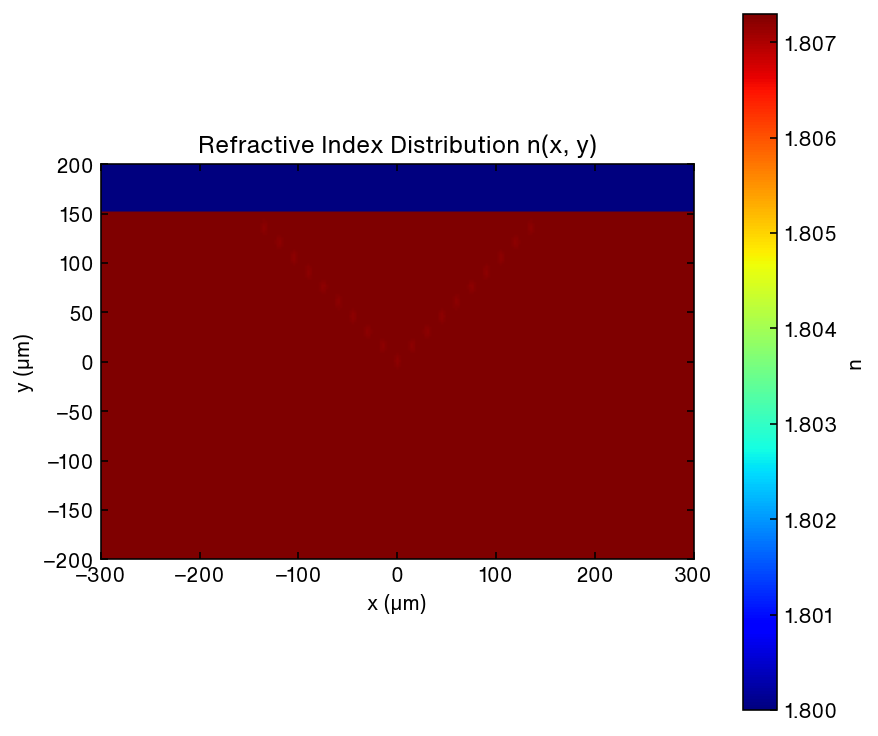

  0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_1599001/2206565413.py:199: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


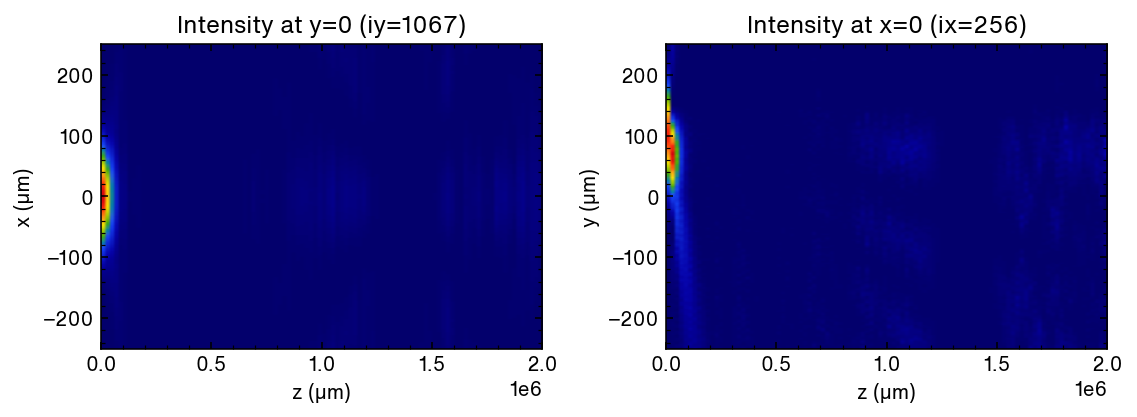

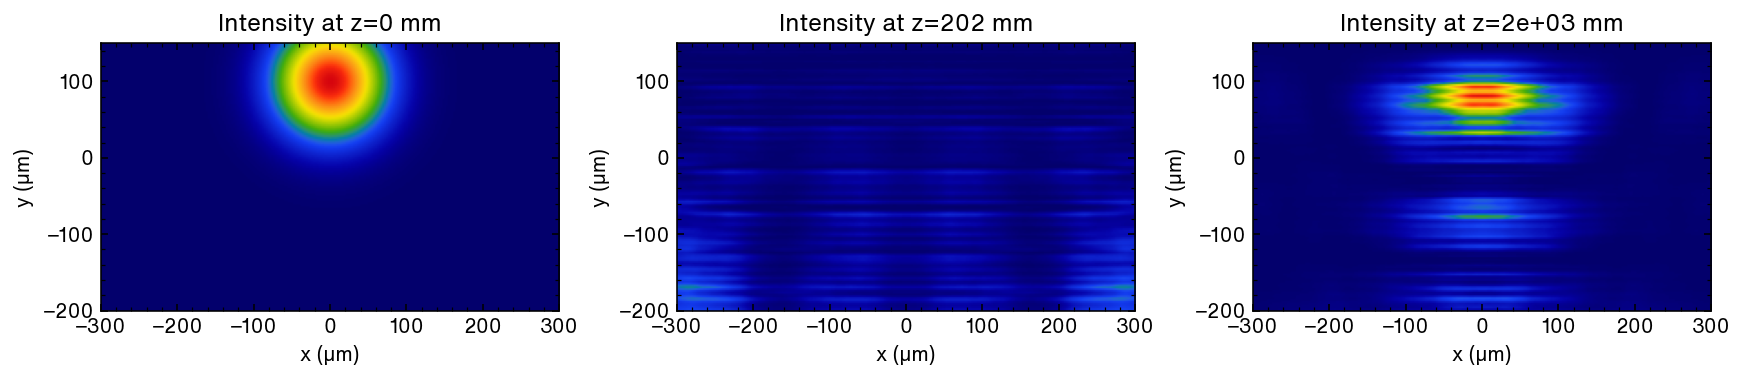

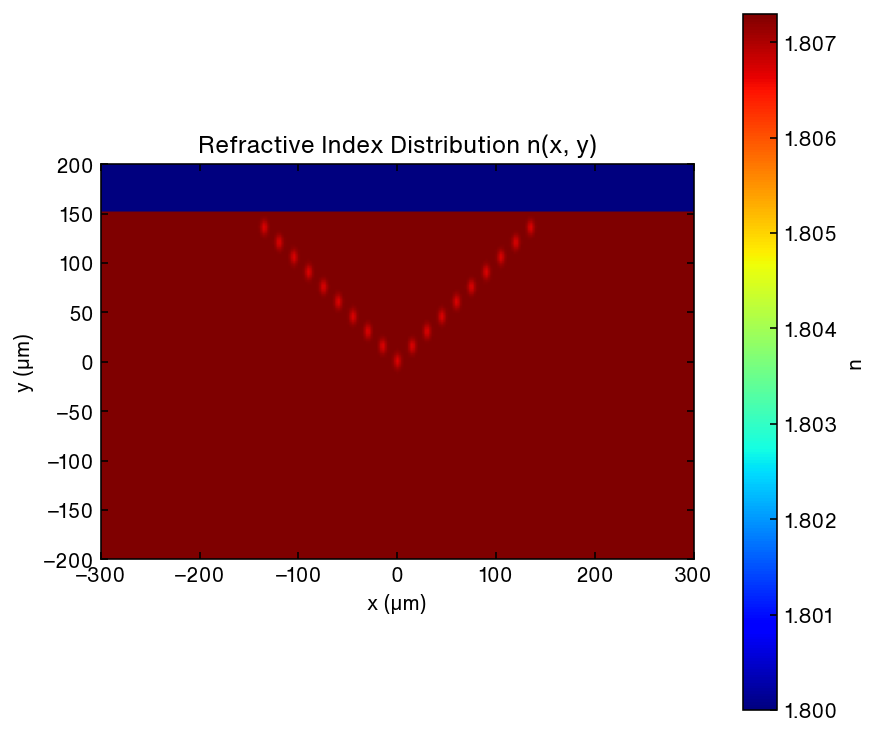

  0%|          | 0/100000 [00:00<?, ?it/s]

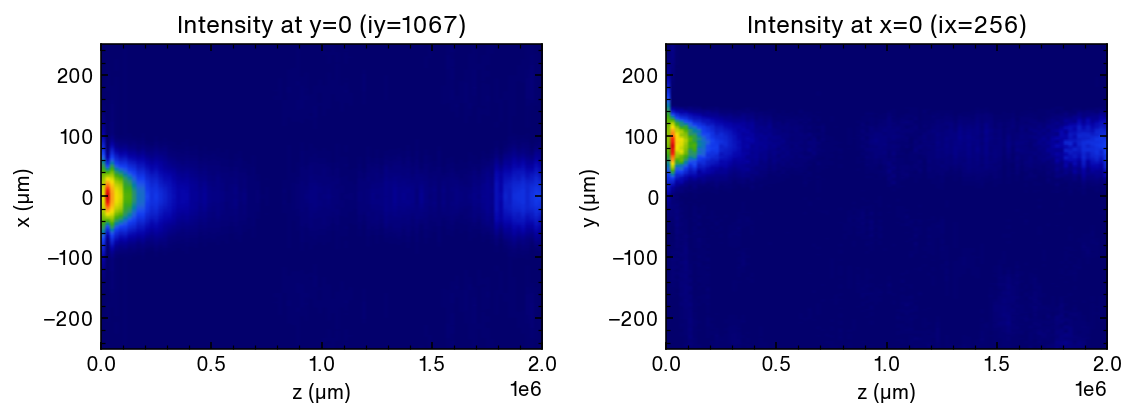

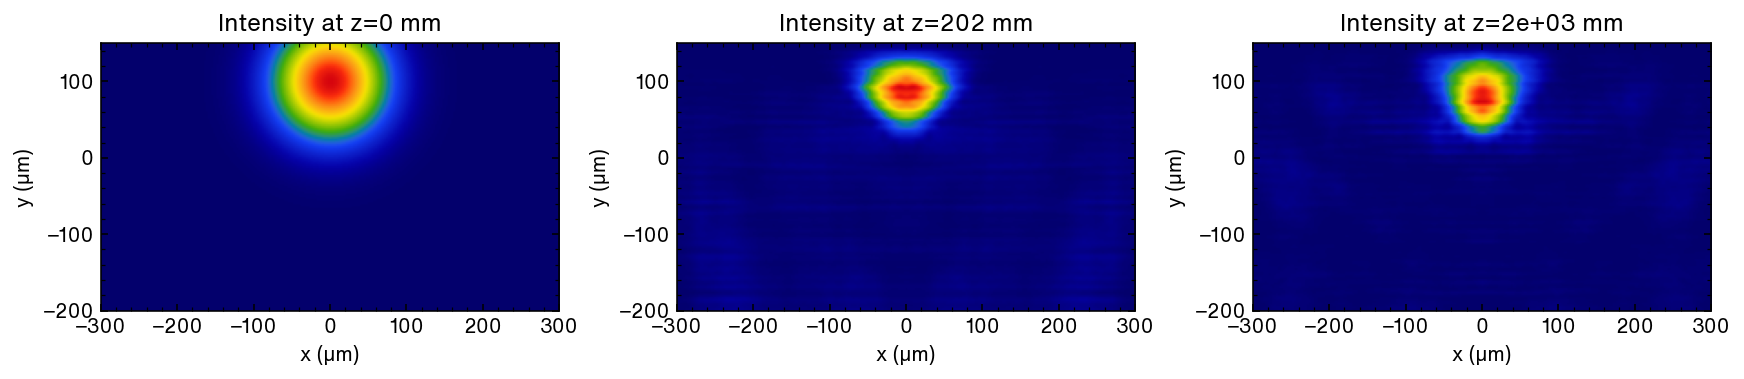

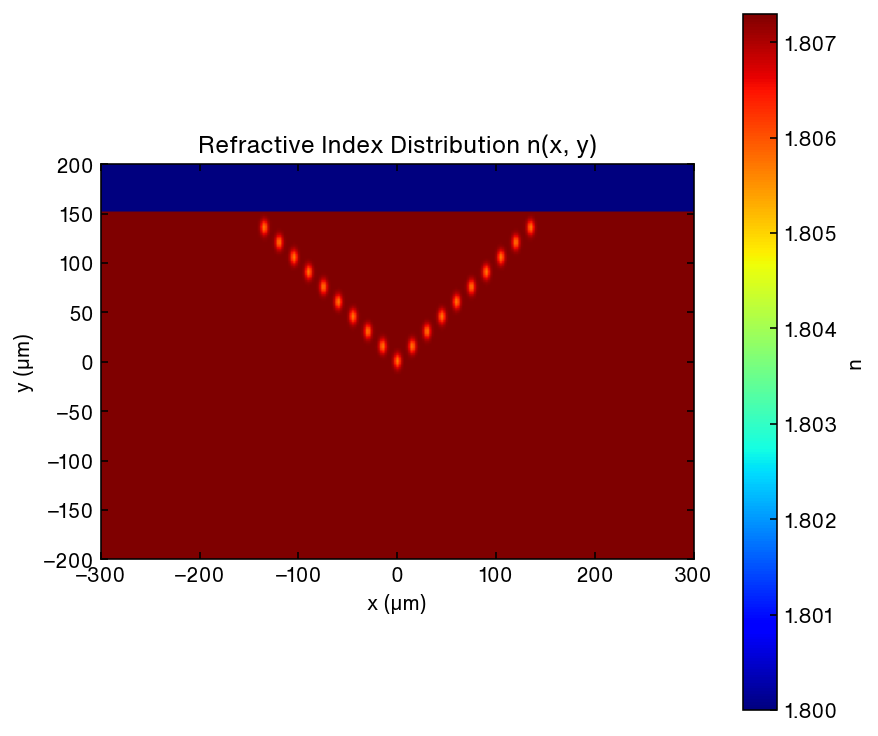

  0%|          | 0/100000 [00:00<?, ?it/s]

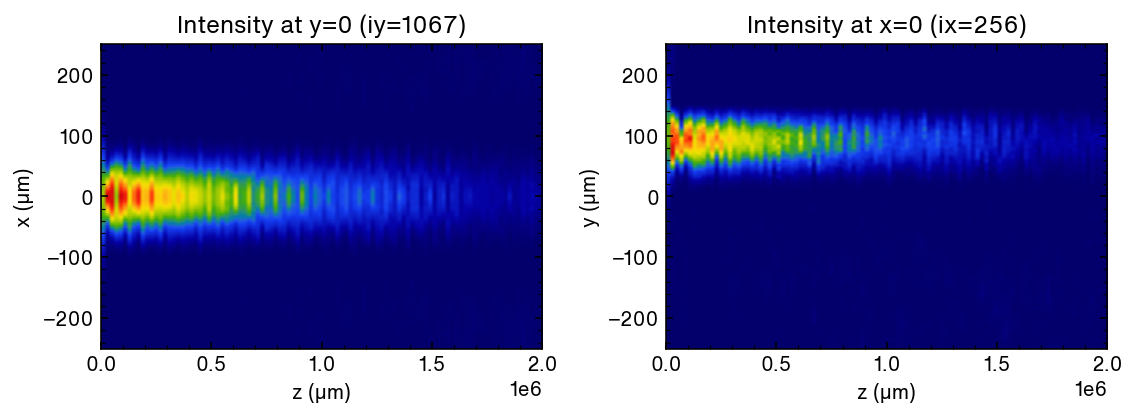

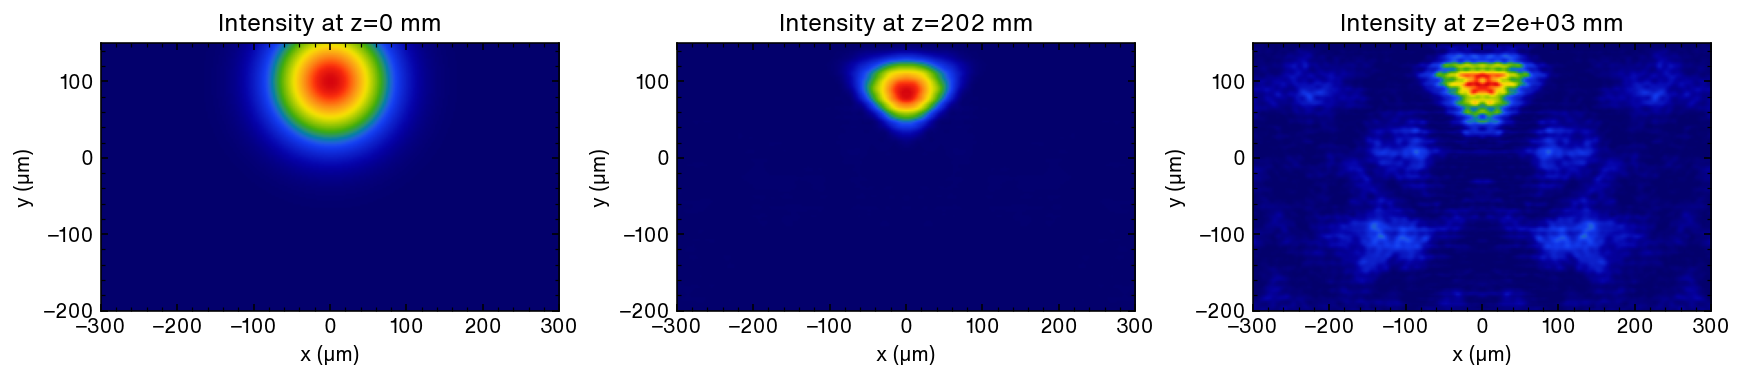

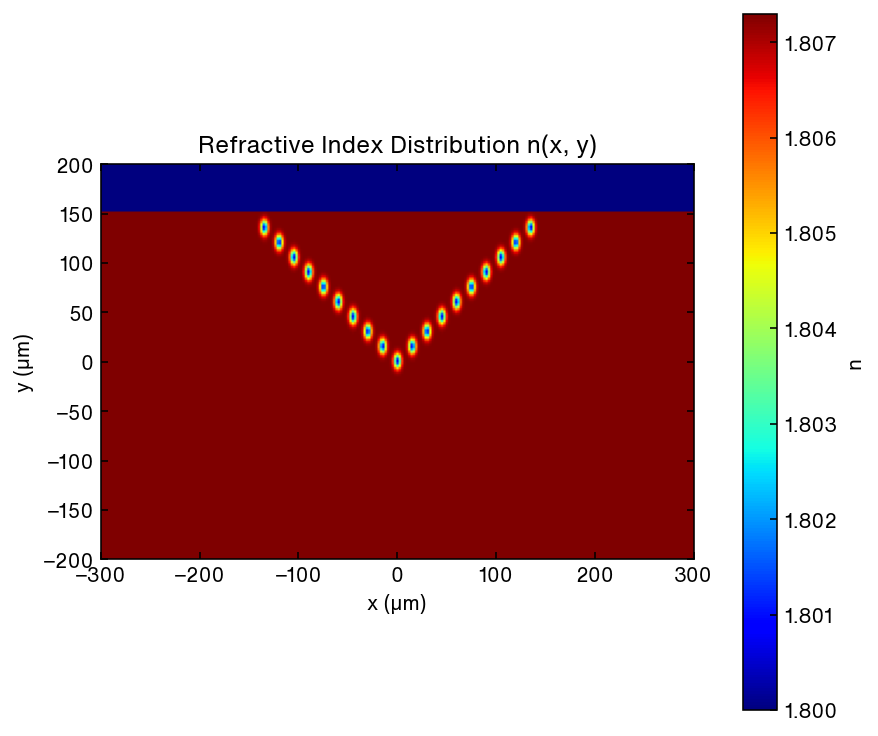

  0%|          | 0/100000 [00:00<?, ?it/s]

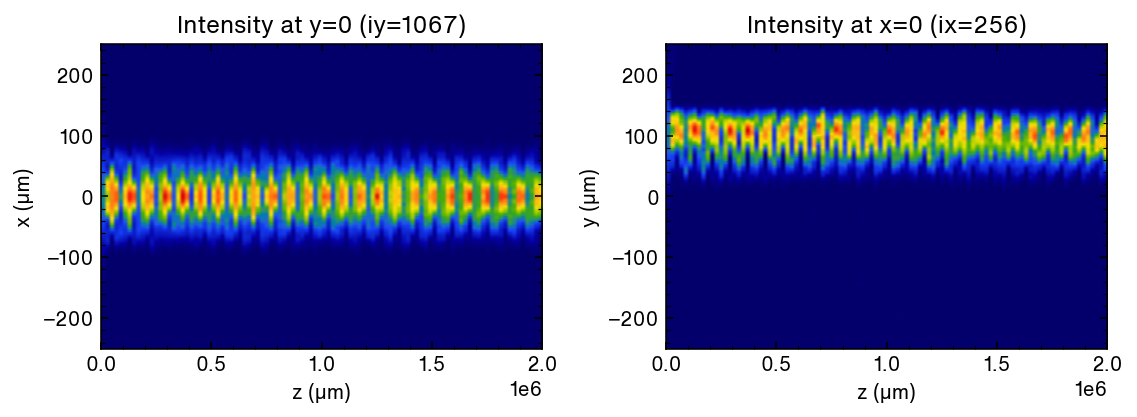

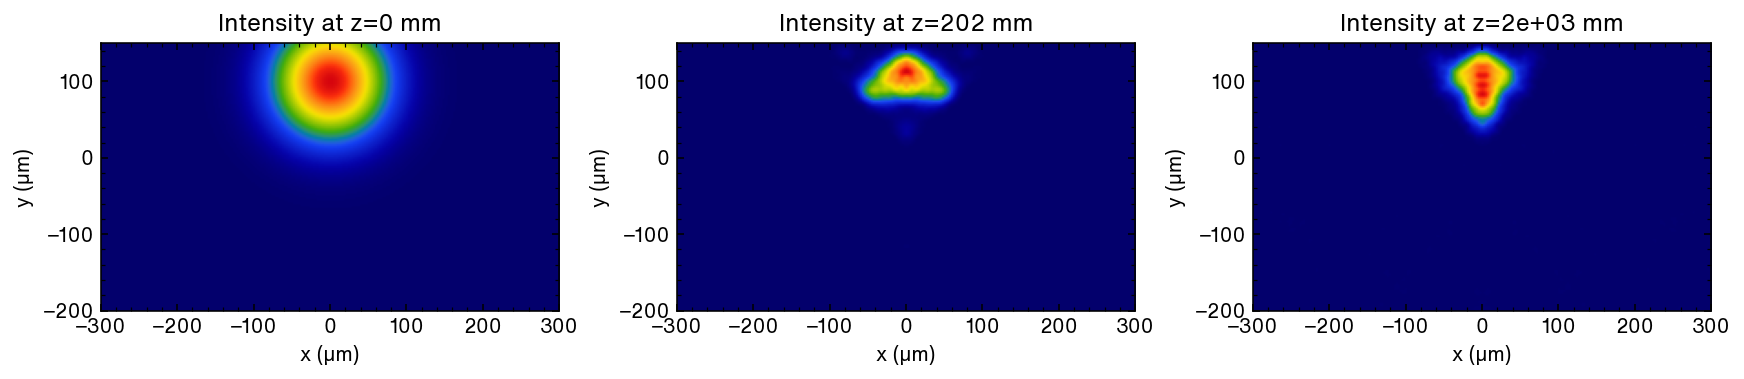

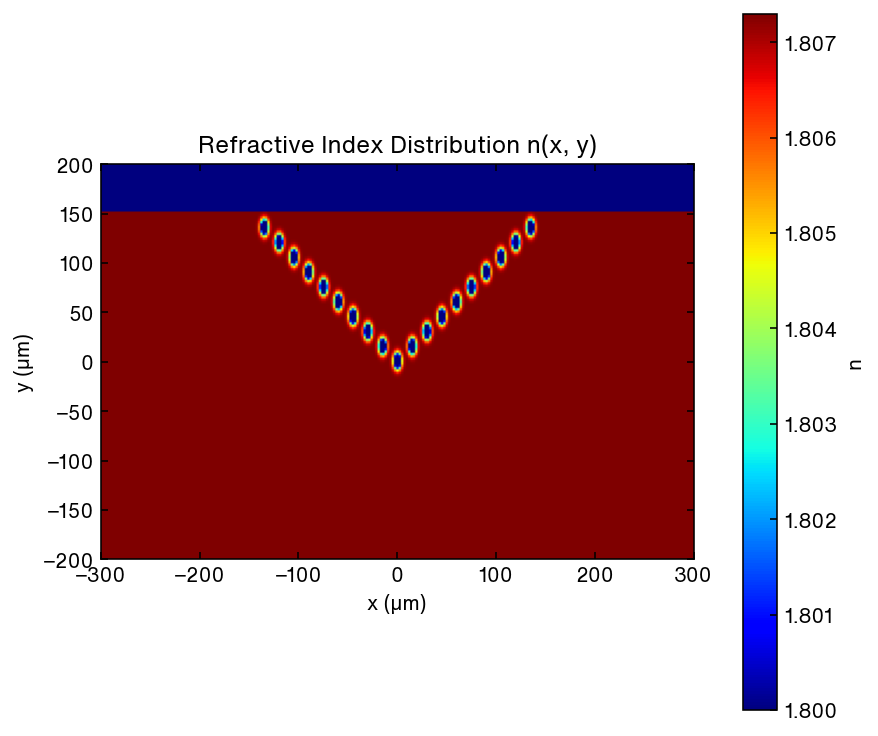

  0%|          | 0/100000 [00:00<?, ?it/s]

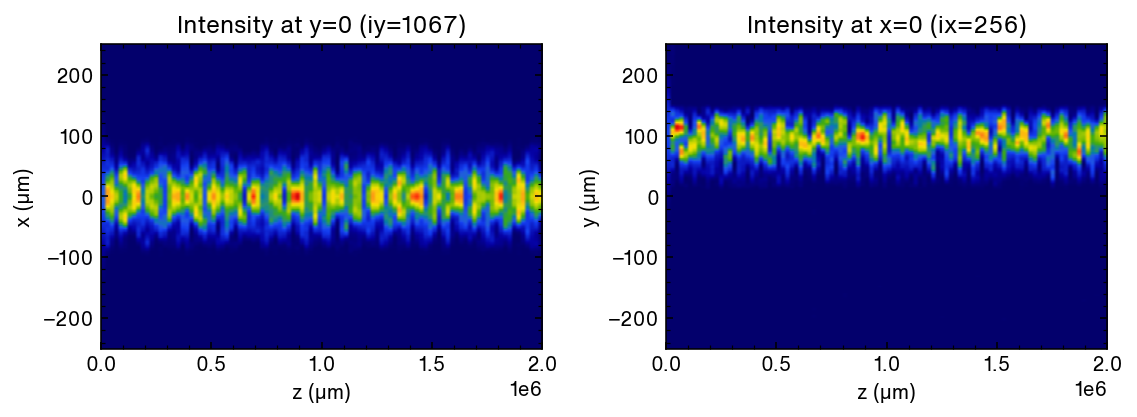

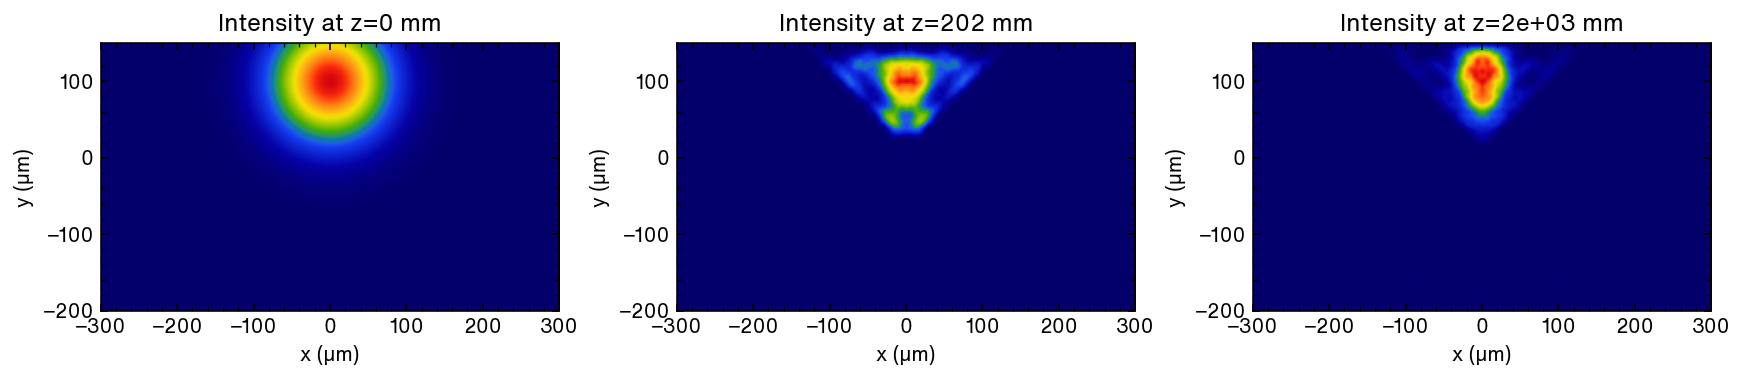

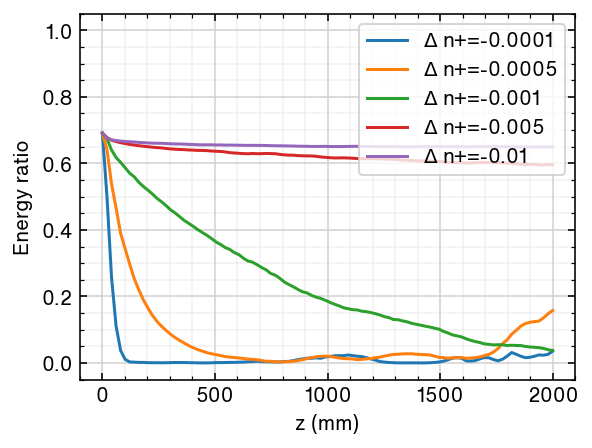

In [295]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
# ユーザ独自の BPM 実装があると仮定。必要に応じて読み込んでください。
# from your_bpm_module import bpm_propagation, DiffractionMode

#####################################################
# 0. パラメータの初期設定
#####################################################
# シミュレーション領域
LX = 1000e-6   # x方向サイズ [m]
LY = 4000e-6   # y方向サイズ [m]
LZ = 2000e-3    # z方向サイズ (伝搬距離) [m]

# 光学パラメータ
wavelengthp = 0.793e-6  # 波長 [m]
wavelength = 2e-6  # 波長 [m]
n0 = 1.8073            # 基準屈折率

# サンプリング間隔
dx = dy = wavelengthp *3  # x,y方向のサンプリング
dz = 20e-6                # z方向のステップ幅

# グリッド数
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

# デバイス（GPU使用）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 出力フォルダ（例）
save_cfolder = f"20240120_multina_Z{round(LZ*1000)}mm"
save_folder = Path.cwd() / save_cfolder
save_folder.mkdir(exist_ok=True, parents=True)

# x, y座標配列
x = (torch.arange(Nx) - Nx//2) * dx
y = (torch.arange(Ny) - Ny//2) * dy

# メッシュグリッド (X, Y)
# ここでは [Nx, Ny] の順で行列を作る (PyTorchに合わせて y->行, x->列 でもOK)
# X = x.unsqueeze(0).expand(Ny, Nx).to(device)
# Y = y.unsqueeze(1).expand(Ny, Nx).transpose(0,1).to(device)
# あるいは、以下のようにしてもよい:
X, Y = torch.meshgrid(x, y, indexing='xy')
X = X.to(device)
Y = Y.to(device)
# 基準屈折率分布 n_xy (複素数型で定義しておく)
# (A) 初期電場分布
beam_waist = 100e-6  # 例: ビーム半径など設定
E0 = torch.exp(-(X**2 + (Y-100e-6)**2) / (beam_waist**2)).to(dtype=torch.complex128)
n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)

item_dict={}


for delta_n in (-1e-4, -5e-4, -1e-3, -5e-3, -1e-2):
    #####################################################
    # 1. 任意の数の書き込み座標を受け取り，屈折率変化を付与
    #####################################################

    divisions   = 10                      # 各等辺を10分割
    base_center = (0, 150e-6)         # 底辺の中心 (ステージ原点を含めた座標)
    height      = -150e-6                     # 三角形の高さ [m]
    base_length = 300e-6                     # 底辺の長さ [m]
    f           = n0# 既存のスケール係数
    radius = 50e-6
    xs=[]
    ys=[]
    waveguide_params= []
    bwx = 5e-6
    bwy = 10e-6
    # delta_n=-1e-3
    # トータルで divisions*2 本のラインを書き込む
    for i in range(divisions*2 -1):
        wxc,  wyc = get_xz_on_triangle(i, divisions, base_center, height, base_length, f)
        # (wxc, wyc, bwx, bwy, na) の形で自由に定義
        waveguide_params.append((wxc,  wyc, bwx, bwy, delta_n))



    for (wxc, wyc, bwx, bwy, na) in waveguide_params:
        n_xy = ndown(n_xy, wxc, wyc, bwx, bwy, na, X, Y)



    #空気の設定
    air_up, air_down = 150e-6, -1850e-6
    mask0 = (Y < air_down) | (air_up < Y)
    n_xy[mask0] = 1.0
    #####################################################
    # 2. 屈折率分布のプロット (実数部)
    #####################################################

    # 今回の座標軸は [x軸:µm, y軸:µm] で表示する
    x_um = x.cpu().numpy() * 1e6
    y_um = y.cpu().numpy() * 1e6

    fig, ax = plt.subplots(figsize=(6, 5))
    # extent: (x_min, x_max, y_min, y_max)
    im = ax.imshow(
        n_xy.real.cpu().numpy(),
        origin='lower',
        extent=(x_um[0], x_um[-1], y_um[0], y_um[-1]),
        cmap='jet',
        vmin=1.8
    )
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    ax.set_title("Refractive Index Distribution n(x, y)")
    cbar = fig.colorbar(im, ax=ax, label="n")
    # 例: 可視化範囲を絞る
    ax.set_xlim(-300, 300)
    ax.set_ylim(-200, 200)
    plt.show()

    #####################################################
    # 3. ビーム伝搬計算
    #####################################################


    # (B) BPMで伝搬
    # サンプリングする z インデックス
    iz_snap = torch.linspace(0, Nz, min(100, Nz+1)).round().to(dtype=torch.int64)
    z_snap = dz * iz_snap
    Eloop = E0
    E_snap = bpm_propagation(
                Eloop,
                Nz,
                dx,
                dy,
                dz,
                wavelength,
                n0,
                n_xy,
                iz_snap,
                diffraction_mode=DiffractionMode.PARAXIAL,
                # diffraction_mode=DiffractionMode.WIDEANGLE,
            )


    # (C) 計算結果の可視化 (強度プロット)
    I_snap = torch.abs(E_snap)**2  # [num_snap, Ny, Nx]

    # プロット例
    cmap = "jet"  # "cet_rainbow4" を使うなら pip install colorcet など

    # zスナップ方向を0軸にしている場合に注意してインデックスを合わせる
    # I_snap.shape = (len(iz_snap), Ny, Nx)

    # y=0付近の断面を見る -> y座標 0 に最も近いインデックスを検索
    iyc = torch.searchsorted(y, 0.0).item()
    # x=0付近の断面を見る -> x座標 0 に最も近いインデックスを検索
    ixc = torch.searchsorted(x, 0.0).item()

    vmin = 0
    vmax = I_snap.max().item()

    # I_snap[:, iyc, :] の shape : [len(iz_snap), Nx] に注意
    # ただし I_snap は [len(iz_snap), Ny, Nx] の順で保持しているので、(iyc, Nx) を抜き出すなら
    # 次のように転置して表示を合わせる

    # I_snap から強度分布
    # 例: final_E_snap = E_snap
    # I_snap = torch.abs(final_E_snap)**2

    # --------------------------------------------------
    # (A) y=0, x=0 断面のプロット
    # --------------------------------------------------
    fig, axr = plt.subplots(1, 2, figsize=(8, 3))

    # y=0 断面 (x-z面)
    plot_y_eq_0(
        I_snap,
        x, y,
        z_snap,
        dx, dy, dz,
        ax=axr[0],
        x_range=(-250, 250),
        cmap="cet_rainbow4",
        k= 100e-6
    )

    # x=0 断面 (y-z面)
    plot_x_eq_0(
        I_snap,
        x, y,
        z_snap,
        dx, dy, dz,
        ax=axr[1],
        y_range=(-250, 250),
        cmap="cet_rainbow4"
    )

    for ax in axr:
        ax.minorticks_on()

    plt.tight_layout()
    plt.savefig(save_folder / f"XZandYZ_n{na:e}.png")
    plt.show()


    # --------------------------------------------------
    # (B) 同一図に z=0, z=中間, z=終端など3枚の x-yプロファイル
    # --------------------------------------------------
    fig, axr = plt.subplots(1, 3, figsize=(12, 3))

    index_list = [0, len(iz_snap)//10, len(iz_snap)-1]
    for i, idx_z in enumerate(index_list):
        # 例: z座標をタイトルに入れる
        z_m = iz_snap[idx_z].item() * dz  # [m]
        title_str = f"Intensity at z={z_m*1e3:.3g} mm"

        plot_z_slice(
            I_snap,
            x, y,
            idx_z,
            dx, dy,
            ax=axr[i],
            x_range=(-300, 300),
            y_range=(-200, 150),
            cmap="cet_rainbow4",
            title=title_str
        )
        axr[i].minorticks_on()

    plt.savefig(save_folder / f"XYprofile_diffZ_n{na:e}.png")
    plt.show()

################
#導波路内のエネルギーの計算，形状は逐一定義
################
    maskWG = (
            (Y > X )
            & (Y > - X)
            & (Y < 150e-6)
        )
    energy_total = I_snap.sum(dim=(-1, -2))
    
    I_snap_inner = I_snap.clone()
    I_snap_inner[:, ~maskWG] = 0.0
    energy_inner = I_snap_inner.sum(dim=(-1, -2))
    item_dict[delta_n] = [
        1e6 * z_snap.cpu().numpy(),
        (energy_total / energy_total[0]).cpu().numpy(),
        (energy_inner / energy_total[0]).cpu().numpy(),
        ]
fig, ax = plt.subplots()
for key in item_dict.keys():
    # ax.plot(
    #     item_dict[key][0] * 1e-3,
    #     item_dict[key][1],
    #     label=r"Total $\Delta$ n=" + str(key),
    # )
    ax.plot(
        item_dict[key][0] * 1e-3,
        item_dict[key][2],
        label=r"$\Delta$ n+=" + str(key),
    )
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (mm)")
ax.set_ylabel("Energy ratio")
save_path4 = save_folder / "energy_ratio.png"
fig.savefig(save_path4)
None


### GIF生成して繰り返し表示

GIF saved to triangle.gif



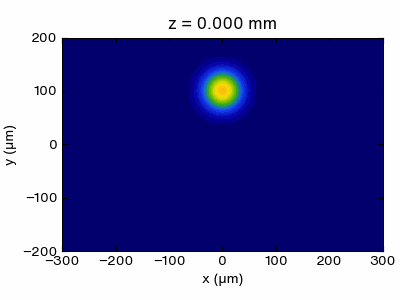

In [293]:
import torch
import matplotlib.pyplot as plt
import io
import imageio
import numpy as np
from PIL import Image, ImageSequence
iz_snap = torch.linspace(0, Nz, min(100, Nz+1)).round().to(dtype=torch.int64)
z_snap = dz * iz_snap
x_range = (-300, 300)
y_range = (-200, 200)
gif_file = input() +".gif"
create_gif_animation(
    I_snap,
    x, y,
    dx, dy,
    z_snap,
    gif_file,
    fps=10,
    cmap="cet_rainbow4",
    x_range=x_range,
    y_range=y_range,
    bunkatsu=1
)

with open(gif_file,"rb") as f:
    b64 = base64.b64encode(f.read()).decode()

html = f'<img src="data:image/gif;base64,{b64}" alt="Beam" />'
display(HTML(html))

## circle

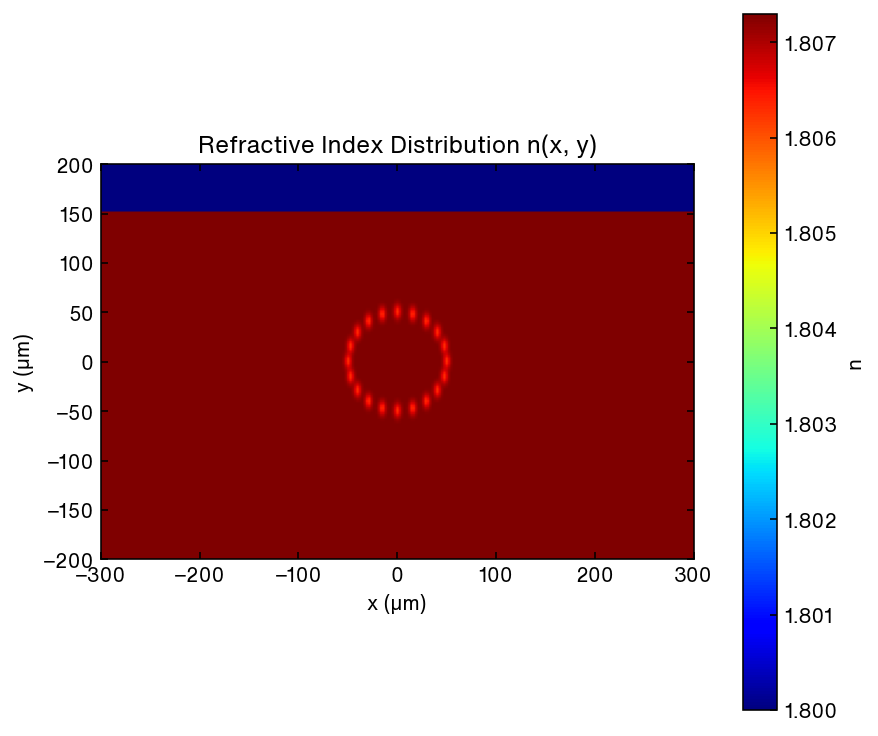

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1599001/1459174913.py:208: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


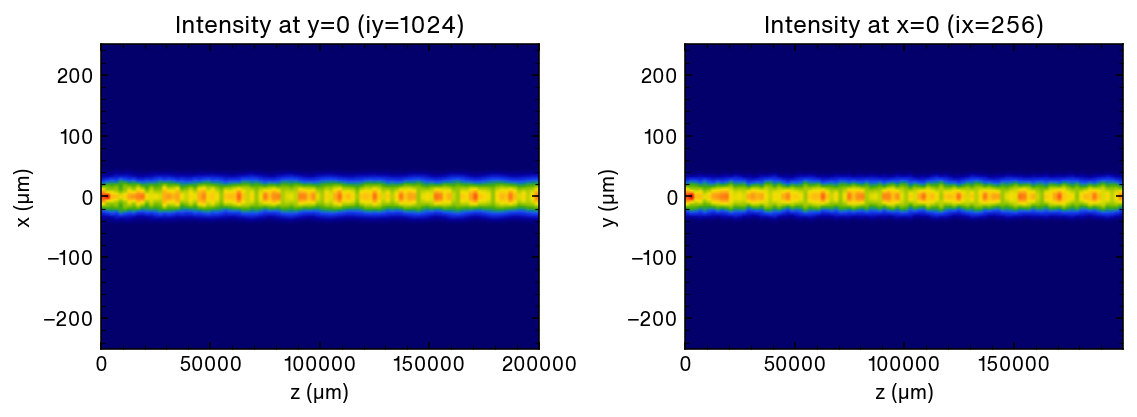

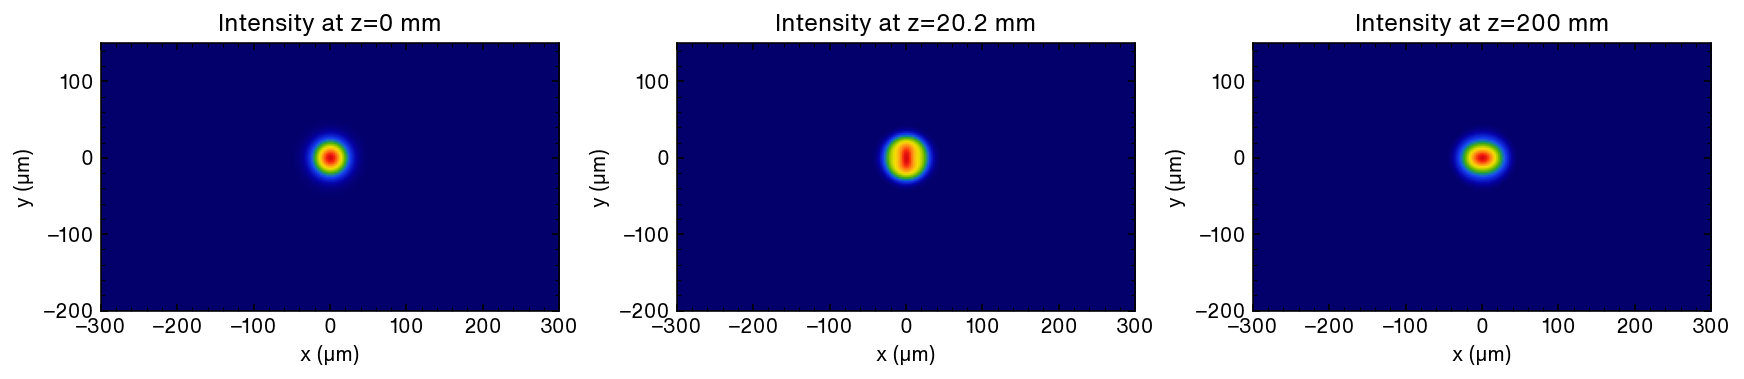

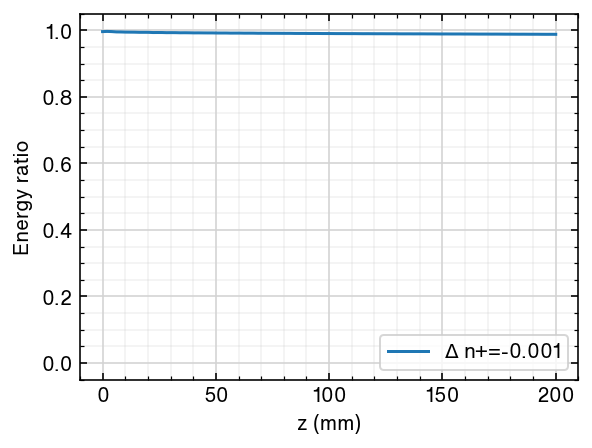

In [ ]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
# ユーザ独自の BPM 実装があると仮定。必要に応じて読み込んでください。
# from your_bpm_module import bpm_propagation, DiffractionMode

#####################################################
# 0. パラメータの初期設定
#####################################################
# シミュレーション領域
LX = 1000e-6   # x方向サイズ [m]
LY = 4000e-6   # y方向サイズ [m]
LZ = 200e-3    # z方向サイズ (伝搬距離) [m]

# 光学パラメータ
wavelength = 0.793e-6  # 波長 [m]
n0 = 1.8073            # 基準屈折率

# サンプリング間隔
dx = dy = wavelength*3  # x,y方向のサンプリング
dz = 20e-6                # z方向のステップ幅

# グリッド数
Nx = 1 << (round(LX / dx) - 1).bit_length()
Ny = 1 << (round(LY / dy) - 1).bit_length()
Nz = round(LZ / dz)

# デバイス（GPU使用）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 出力フォルダ（例）
save_cfolder = f"20240120_multina_Z{round(LZ*1000)}mm"
save_folder = Path.cwd() / save_cfolder
save_folder.mkdir(exist_ok=True, parents=True)

# x, y座標配列
x = (torch.arange(Nx) - Nx//2) * dx
y = (torch.arange(Ny) - Ny//2) * dy

# メッシュグリッド (X, Y)
# ここでは [Nx, Ny] の順で行列を作る (PyTorchに合わせて y->行, x->列 でもOK)
# X = x.unsqueeze(0).expand(Ny, Nx).to(device)
# Y = y.unsqueeze(1).expand(Ny, Nx).transpose(0,1).to(device)
# あるいは、以下のようにしてもよい:
X, Y = torch.meshgrid(x, y, indexing='xy')
X = X.to(device)
Y = Y.to(device)
# 基準屈折率分布 n_xy (複素数型で定義しておく)

# (A) 初期電場分布
beam_waist = 30e-6  # 例: ビーム半径など設定
# E0 = torch.exp(-(X**2 + (Y-100e-6)**2) / (beam_waist**2)).to(dtype=torch.complex128)
E0 = torch.exp(-(X**2 + (Y)**2) / (beam_waist**2)).to(dtype=torch.complex128)
n_xy = n0 * torch.ones_like(E0, dtype=torch.complex128)
item_dict={}



for delta_n in ([-1e-3]):

    #####################################################
    # 1. 任意の数の書き込み座標を受け取り，屈折率変化を付与
    #####################################################

    divisions   = 20                      # 各等辺を10分割
    base_center = (0, 150e-6)         # 底辺の中心 (ステージ原点を含めた座標)
    height      = -100e-6                     # 三角形の高さ [m]
    base_length = 200e-6                     # 底辺の長さ [m]
    f           = n0# 既存のスケール係数
    radius = 50e-6
    xs=[]
    ys=[]
    waveguide_params= []
    bwx = 5e-6
    bwy = 10e-6
    # トータルで divisions*2 本のラインを書き込む
    # for i in range(divisions*2 -1):
    #     wxc,  wyc = get_xz_on_triangle(i, divisions, base_center, height, base_length, f)
    #     # (wxc, wyc, bwx, bwy, na) の形で自由に定義
    #     waveguide_params.append((wxc,  wyc, bwx, bwy, -1e-2))


    #円状導波路
    for i in range(divisions):
        wxc,  wyc = get_xz_on_circle(i, divisions, (0,0), radius)
        # (wxc, wyc, bwx, bwy, na) の形で自由に定義
        waveguide_params.append((wxc,  wyc, bwx, bwy, delta_n))

    for (wxc, wyc, bwx, bwy, na) in waveguide_params:
        n_xy = ndown(n_xy, wxc, wyc, bwx, bwy, na, X, Y)



    #空気の設定
    air_up, air_down = 150e-6, -1850e-6
    mask0 = (Y < air_down) | (air_up < Y)
    n_xy[mask0] = 1.0



    #####################################################
    # 2. 屈折率分布のプロット (実数部)
    #####################################################

    # 今回の座標軸は [x軸:µm, y軸:µm] で表示する
    x_um = x.cpu().numpy() * 1e6
    y_um = y.cpu().numpy() * 1e6

    fig, ax = plt.subplots(figsize=(6, 5))
    # extent: (x_min, x_max, y_min, y_max)
    im = ax.imshow(
        n_xy.real.cpu().numpy(),
        origin='lower',
        extent=(x_um[0], x_um[-1], y_um[0], y_um[-1]),
        cmap='jet',
        vmin=1.8
    )
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    ax.set_title("Refractive Index Distribution n(x, y)")
    cbar = fig.colorbar(im, ax=ax, label="n")
    # 例: 可視化範囲を絞る
    ax.set_xlim(-300, 300)
    ax.set_ylim(-200, 200)
    plt.show()

    #####################################################
    # 3. ビーム伝搬計算
    #####################################################


    # (B) BPMで伝搬
    # サンプリングする z インデックス
    iz_snap = torch.linspace(0, Nz, min(100, Nz+1)).round().to(dtype=torch.int64)
    z_snap = dz * iz_snap
    Eloop = E0
    E_snap = bpm_propagation(
                Eloop,
                Nz,
                dx,
                dy,
                dz,
                wavelength,
                n0,
                n_xy,
                iz_snap,
                diffraction_mode=DiffractionMode.PARAXIAL,
                # diffraction_mode=DiffractionMode.WIDEANGLE,
            )


    # (C) 計算結果の可視化 (強度プロット)
    I_snap = torch.abs(E_snap)**2  # [num_snap, Ny, Nx]

    # プロット例
    cmap = "jet"  # "cet_rainbow4" を使うなら pip install colorcet など

    # zスナップ方向を0軸にしている場合に注意してインデックスを合わせる
    # I_snap.shape = (len(iz_snap), Ny, Nx)

    # y=0付近の断面を見る -> y座標 0 に最も近いインデックスを検索fff
    iyc = torch.searchsorted(y, 0.0).item()
    # x=0付近の断面を見る -> x座標 0 に最も近いインデックスを検索v
    ixc = torch.searchsorted(x, 0.0).item()

    vmin = 0
    vmax = I_snap.max().item()

    # I_snap[:, iyc, :] の shape : [len(iz_snap), Nx] に注意
    # ただし I_snap は [len(iz_snap), Ny, Nx] の順で保持しているので、(iyc, Nx) を抜き出すなら
    # 次のように転置して表示を合わせる

    # I_snap から強度分布
    # 例: final_E_snap = E_snap
    # I_snap = torch.abs(final_E_snap)**2

    # --------------------------------------------------
    # (A) y=0, x=0 断面のプロット
    # --------------------------------------------------
    fig, axr = plt.subplots(1, 2, figsize=(8, 3))

    # y=0 断面 (x-z面)
    plot_y_eq_0(
        I_snap,
        x, y,
        z_snap,
        dx, dy, dz,
        ax=axr[0],
        x_range=(-250, 250),
        cmap="cet_rainbow4",
        k= 0
    )

    # x=0 断面 (y-z面)
    plot_x_eq_0(
        I_snap,
        x, y,
        z_snap,
        dx, dy, dz,
        ax=axr[1],
        y_range=(-250, 250),
        cmap="cet_rainbow4"
    )

    for ax in axr:
        ax.minorticks_on()

    plt.tight_layout()
    plt.savefig(save_folder / f"XZandYZ_n{na:e}.png")
    plt.show()


    # --------------------------------------------------
    # (B) 同一図に z=0, z=中間, z=終端など3枚の x-yプロファイル
    # --------------------------------------------------
    fig, axr = plt.subplots(1, 3, figsize=(12, 3))

    index_list = [0, len(iz_snap)//10, len(iz_snap)-1]
    for i, idx_z in enumerate(index_list):
        # 例: z座標をタイトルに入れる
        z_m = iz_snap[idx_z].item() * dz  # [m]
        title_str = f"Intensity at z={z_m*1e3:.3g} mm"

        plot_z_slice(
            I_snap,
            x, y,
            idx_z,
            dx, dy,
            ax=axr[i],
            x_range=(-300, 300),
            y_range=(-200, 150),
            cmap="cet_rainbow4",
            title=title_str
        )
        axr[i].minorticks_on()

    plt.savefig(save_folder / f"XYprofile_diffZ_n{na:e}.png")
    plt.show()


    ################
    #導波路内のエネルギーの計算，形状は逐一定義
    ################
    maskWG = (
            (Y**2 + X**2)**(0.5) < 50e-6 
        )
    energy_total = I_snap.sum(dim=(-1, -2))
    
    I_snap_inner = I_snap.clone()
    I_snap_inner[:, ~maskWG] = 0.0
    energy_inner = I_snap_inner.sum(dim=(-1, -2))
    item_dict[delta_n] = [
        1e6 * z_snap.cpu().numpy(),
        (energy_total / energy_total[0]).cpu().numpy(),
        (energy_inner / energy_total[0]).cpu().numpy(),
        ]
fig, ax = plt.subplots()
for key in item_dict.keys():
    # ax.plot(
    #     item_dict[key][0] * 1e-3,
    #     item_dict[key][1],
    #     label=r"Total $\Delta$ n=" + str(key),
    # )
    ax.plot(
        item_dict[key][0] * 1e-3,
        item_dict[key][2],
        label=r"$\Delta$ n+=" + str(key),
    )
ax.plot(0, 0)
ax.plot(0, 1)
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
ax.set_xlabel("z (mm)")
ax.set_ylabel("Energy ratio")
save_path4 = save_folder / "energy_ratio.png"
fig.savefig(save_path4)


GIF saved to ./my_profile_animation.gif



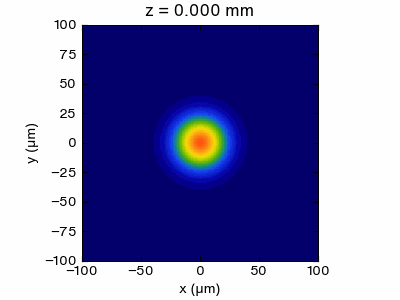

In [291]:


# -------------------------------------------------------------
# 使い方イメージ (BPM計算後)
# -------------------------------------------------------------
# I_snap : shape = (len(iz_snap), Ny, Nx)
# x, y   : 1D tensor
# dx, dy : float
# z_snap : (len(iz_snap), )  [m単位のzステップ]

"""
# 例: BPM計算した結果が揃っていると仮定
final_E_snap = E_snap  # (len(iz_snap), Ny, Nx)
I_snap = torch.abs(final_E_snap)**2

# x_range, y_range は任意で設定
x_range = (-300, 300)
y_range = (-200, 200)

# たとえばフレームを全部使う（フレーム数多い場合は注意）

"""
x_range = (-100, 100)
y_range = (-100, 100)
gif_file = "./my_profile_animation.gif"
create_gif_animation(
    I_snap,
    x, y,
    dx, dy,
    z_snap,
    gif_file,
    fps=10,
    cmap="cet_rainbow4",
    x_range=x_range,
    y_range=y_range,
    bunkatsu=1
)

with open("my_profile_animation.gif","rb") as f:
    b64 = base64.b64encode(f.read()).decode()

html = f'<img src="data:image/gif;base64,{b64}" alt="Beam" />'
display(HTML(html))
